[View in Colaboratory](https://colab.research.google.com/github/robmoore/diabetes-prediction/blob/master/PF+Diabetes+Challenge+with+Meta_data.ipynb)

# Intro

In 2012, in partnership with Kaggle, Practice Fusion held a [competition](https://www.kaggle.com/c/pf2012-diabetes) to predict patients with a diagnosis for diabetes mellitus from a data set of de-identified data. We use the data below to get a feel for working with de-identified patient data.
There are a total of 9,948 patients in the training set and 4,979 patients in the test set. An indicator column (`dmIndicator`) has been added to show who has a diagnosis of Type 2 diabetes mellitus.
The original data contained CSV files as well as a [SQLite](https://www.sqlite.org/) database. In the work below, we use the SQLite database solely. The original data was removed from the Kaggle site at the request of Practice Fusion. It appears that a copy of that data exists in the [Github repo](https://github.com/yasminlucero/Kaggle) of `yasminlucero`.
The [data dictionary and data model document](https://github.com/yasminlucero/Kaggle/raw/master/Data/PracticeFusionDataSetDictionary.pdf) provided by Practice Fusion provides a good level of detail.

## Motivation
Over 25 million people, or nearly 8.3% of the entire United States population, have diabetes. Diabetes is also associated with a wide range of complications from heart disease and stroke to blindness and kidney disease. Predicting who has diabetes will lead to a better understanding of these complications and the common comorbidities that diabetics suffer.

## Challenge
Given a de-identified data set of patient electronic health records, build a model to determine who has a Type 2 diabetes mellitus (T2DM) diagnosis, as defined by ICD9 codes 250, 250.0, 250.\*0 or 250.\*2 (e.g., 250, 250.0, 250.00, 250.10, 250.52, etc).

## Data Modifications
Here's a brief outline of the steps taken to prepare the original dataset into the training set and test sets. The full description is listed on the [Kaggle](https://www.kaggle.com/c/pf2012-diabetes#datasetpreparation) site.
- Removed patients that have diagnoses for diabetes complications without a basic diagnosis of Type II diabetes mellitus (T2DM), as defined by ICD9 codes 250, 250.0, 250.\*0 or 250.\*2, from all tables in both data sets. This is 46 patients in the training set, 20 patients in test set. Removing patients requires removing all instances of their `PatientGuid` from **all tables**.
- Removed rows from `SyncDiagnosis` with ICD9 codes 250, 250.0, 250.\*0 or 250.\*2 or ICD9 codes for diabetes complications 357.2, 362.0\* (e.g., 362.01, 362.05), or 250.1, 250.2, ... , 250.9. These rows identify a set of `DiagnosisGuid` that need to be removed from `SyncTranscriptDiagnosis`. Removed the field `OrderBy` in `SyncTranscriptDiagnosis` entirely.
- Removed rows from `SyncMedication` which references a diabetes medication. These rows identify a set of MedicationGuid that need to be removed from `SyncPrescription` and `SyncTranscriptMedicatio`n. Removed the field `OrderBy` in `SyncTranscriptMedication` entirely.
- Removed rows from `LabObservation` where the HL7Text identifies glucose or insulin related labs. These rows identify a set of `LabObservationGuid` that need to be removed from `LabResult`. The rows in `LabResult` identify a set of `LabResultGuid` that need to be removed from `LabResult` and `LabPanel`. Removed any rows from `LabPanel` where the panel name relates to glucose, insulin HbA1c, etc measurements.

## Initialization and Data processing

In [0]:
%matplotlib inline

In [0]:
import warnings
# Ignore warnings about future deprecations
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

import tempfile
import itertools

import sqlite3
import pandas as pd
import numpy as np

from patsy import dmatrices

from contextlib import closing

from pandas.api.types import CategoricalDtype

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import auth
auth.authenticate_user()
project_id = 'carbon-web-124017'
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
tmp_dir=tempfile.mkdtemp()

In [0]:
bucket_name = 'epf-datalab'
!gsutil -m cp -n gs://{bucket_name}/Data/compData.db gs://{bucket_name}/Data/rxnorm.db gs://{bucket_name}/Data/dxref_2015.db gs://{bucket_name}/Data/dcsi.csv gs://{bucket_name}/Data/MEDI_01212013_HPS.csv gs://{bucket_name}/Data/icd9dx2015.db {tmp_dir}

Copying gs://epf-datalab/Data/compData.db...
Copying gs://epf-datalab/Data/rxnorm.db...
Copying gs://epf-datalab/Data/dxref_2015.db...
Copying gs://epf-datalab/Data/dcsi.csv...
Copying gs://epf-datalab/Data/MEDI_01212013_HPS.csv...
Copying gs://epf-datalab/Data/icd9dx2015.db...
| [6/6 files][  2.5 GiB/  2.5 GiB] 100% Done 112.5 MiB/s ETA 00:00:00           
Operation completed over 6 objects/2.5 GiB.                                      


In [0]:
df = pd.read_csv('{}/dcsi.csv'.format(tmp_dir))
df = df.drop(['ICD_9_Diagnosis', 'DCSI_Score'], axis=1)
df = df.groupby('Complication')['ICD_9_Code'].agg('|'.join).reset_index(name='ICD_9_Codes')
df

,Complication,ICD_9_Codes
0,Cardiovascular,4400|4401|44020|44021|44022|44023|44024|44029|...
1,Cerebrovascular,435|431|433|434|436
2,Metabolic,2501|2502|2503
3,Nephropathy,2504|580|581|58181|582|583|585|586|5939
4,Neuropathy,3569|2506|3581|9510|9511|9513|3540|3541|3542|3...
5,Peripheral vascular disease,2507|4423|44381|4439|8921|4439|44422|7854|0400...
6,Retinopathy,25050|25051|25052|25053|36201|3621|36283|36253...


In [0]:
#select * from icd9dx2015 where dgns_cd >= '3540' and dgns_cd <= '3559'

def expandIcd9Range(conn, icd9Range):
  #print(icd9Range)
  low, high = icd9Range.split('-', 1)
  results = pd.read_sql_query("""
    SELECT dgns_cd
    FROM   icd9dx2015 
    WHERE  dgns_cd >= '{}' 
       AND dgns_cd <= '{}' 
""".format(low, high), conn)
  return results["dgns_cd"]

df = pd.read_csv('{}/MEDI_01212013_HPS.csv'.format(tmp_dir))
df = df.drop(['DRUG_DESC', 'INDICATION_DESCRIPTION', 'POSSIBLE_LABEL_USE'], axis=1)
df['ICD9'] = df['ICD9'].str.replace('.','')
df['RXCUI_IN'] = df['RXCUI_IN'].astype('str')

db_file = 'file:{}/icd9dx2015.db?mode=ro'.format(tmp_dir)
with closing(sqlite3.connect(db_file, uri=True)) as conn:    
  mask = (df['ICD9'].str.contains("-"))
  df.loc[mask, 'ICD9'] = df.loc[mask, 'ICD9'].apply(lambda x: '|'.join(expandIcd9Range(conn, x)))

df = df.groupby('RXCUI_IN')['ICD9'].apply(lambda x: '|'.join(x)).reset_index(name='ICD9s')

df = pd.DataFrame(df['ICD9s'].str.split('|').tolist(), index=df['RXCUI_IN']).stack()
df = df.reset_index()[[0, 'RXCUI_IN']] # ICD9s is currently labeled 0
df.columns = ['ICD9', 'RXCUI_IN'] # renaming ICD9s
print(df.head())

df = df.groupby('ICD9')['RXCUI_IN'].apply(lambda x: '|'.join(x)).reset_index(name='RXCUI_INs')
df.loc[df['ICD9'] == '6989']

    ICD9 RXCUI_IN
0  37214  1000082
1   6989  1000082
2  33381  1000104
3  33383  1000104
4   7018  1000104


,ICD9,RXCUI_INs
3701,6989,1000082|104592|106955|106964|108118|11002|1142...


In [0]:
seed = 13431
np.random.seed(seed)

db_file = 'file:{}/compData.db?mode=ro'.format(tmp_dir)
with closing(sqlite3.connect(db_file, uri=True)) as conn:    
    patientTranscripts = pd.read_sql_query("""
    SELECT PatientGuid,
        dmIndicator,
        Gender,
        YearOfBirth,
        VisitYear,
        CASE WHEN Height = 0 OR Height =  'NULL' THEN NULL ELSE CAST(Height AS REAL) END AS Height,
        CASE WHEN Weight = 0 THEN NULL ELSE Weight END AS Weight,
        CASE WHEN BMI = 0 THEN NULL ELSE BMI END AS BMI,
        CASE WHEN SystolicBP = 'NULL' THEN NULL ELSE SystolicBP END AS SystolicBP,
        CASE WHEN DiastolicBP = 'NULL' THEN NULL ELSE DiastolicBP END AS DiastolicBP,
        CASE WHEN PhysicianSpecialty = '' THEN NULL ELSE PhysicianSpecialty END AS PhysicianSpecialty,
        CASE WHEN RespiratoryRate = 'NULL' THEN NULL ELSE RespiratoryRate END AS RespiratoryRate
    FROM training_patientTranscript
""", conn)

In [0]:
# https://www.cdc.gov/healthyweight/assessing/index.html
# https://en.wikipedia.org/wiki/Classification_of_obesity
def translateBMI(bmi):
    if bmi <  18.5:
        return 'Underweight'
    elif 18.5 <= bmi <= 24.9:
        return  'Normal'
    elif 25 <= bmi <= 29.9:
        return 'Overweight'
    elif 30 <= bmi <= 34.9:
        return 'Class 1'
    elif 35 <= bmi <= 39.9:
        return 'Class 2'
    else:
        return 'Class 3'
        
# https://www.heart.org/HEARTORG/Conditions/HighBloodPressure/KnowYourNumbers/Understanding-Blood-Pressure-Readings_UCM_301764_Article.jsp
def translateBP(systolicBP, diastolicBP):
    if systolicBP < 120 and diastolicBP < 80:
        return 'Normal'
    elif systolicBP <= 129 and diastolicBP < 80:
        return 'Elevated'
    elif systolicBP <= 139 or 80 <= diastolicBP <= 89:
        return 'Stage 1'
    elif 140 <= systolicBP or 90 <= diastolicBP:
        return 'Stage 2'
    else:
        return 'HT Crisis'
    
def calcAge(yearOfBirth):
    return 2012 - yearOfBirth

# Has a diagnosis of prediabetes or gestational diabetes
def isPreDB(conn):
    return pd.read_sql_query("SELECT DISTINCT PatientGuid, 1 AS PreDB FROM training_diagnosis WHERE ICD9Code IN ('790.29','648.83')", conn)

# Has family history of DM
def hasFhxDM(conn):
    return pd.read_sql_query("SELECT DISTINCT PatientGuid, 1 AS FhxDM FROM training_diagnosis WHERE ICD9Code == 'V18.0'", conn)

# 272.4: Dyslipidemia (Abnormal LDL, HDL, or triglycerides, increasking risk for heart attack)
# 571.8 and 571.9: Nonalcholic fatty liver disease (NAFLD)
# 429.2: Cardiovascular disease
# 585: Kidney disease
# 250.5: retinopathy
# 401-405: Hypertension (high blood pressure)
# 278: Obesity
# 701.2: Acquired acanthosis nigricans
def hasComorbidities(conn):
    return pd.read_sql_query("SELECT DISTINCT PatientGuid, 1 AS CC FROM training_diagnosis WHERE ICD9Code LIKE '585%' OR ICD9Code IN ('272.4', '571.8', '571.9', '429.2', '250.5', '278', '701.2')", conn)

def isHeavySmoker(conn):
    # Note: Necessary to use training_patientSmokingStatus directly rather than patient_smoking as the NIST codes used translate to multiple statuses (1:N)
    return pd.read_sql_query("SELECT DISTINCT PatientGuid, 1 AS HeavySmoker FROM training_patientSmokingStatus WHERE SmokingStatusGuid IN ('02116D5A-F26C-4A48-9A11-75AC21BC4FD3', 'FCD437AA-0451-4D8A-9396-B6F19D8B25E8')", conn)

def isSmoker(conn):
  # Note: Necessary to use training_patientSmokingStatus directly rather than patient_smoking as the NIST codes used translate to multiple statuses (1:N)
  return pd.read_sql_query("""
SELECT DISTINCT PatientGuid, 1 AS Smoker 
FROM training_patientSmokingStatus 
WHERE SmokingStatusGuid IN ('02116D5A-F26C-4A48-9A11-75AC21BC4FD3', 'FCD437AA-0451-4D8A-9396-B6F19D8B25E8', 'FA2B7AE4-4D14-4768-A8C7-55B5F0CDF4AF', 'DD01E545-D7AF-4F00-B248-9FD40010D81D', '2548BD83-03AE-4287-A578-FA170F39E32F')
""", conn)
  
# Has high triglyceride values
def hasHighTG(conn):
    return pd.read_sql_query("SELECT DISTINCT PatientGuid, 1 AS HighTG FROM training_labs WHERE HL7Text = 'Triglyceride' AND IsAbnormalValue = 1", conn)
  
def diagnosesByPatient(conn):
  return pd.read_sql_query("""
SELECT DISTINCT PatientGuid, replace(ICD9Code, '.', '') AS ICD9
FROM training_diagnosis d
WHERE Acute = 0
ORDER BY PatientGuid
""", conn)
  
def labsByPatient(conn):
  return pd.read_sql_query("""
SELECT DISTINCT PatientGuid, HL7Identifier
FROM training_labs
ORDER BY PatientGuid
""", conn)     
  
def dxCountByPatient(conn):
  return pd.read_sql_query("""
SELECT PatientGuid, COUNT(DISTINCT ICD9Code) AS DXCount
FROM training_diagnosis
WHERE Acute = 0
GROUP BY PatientGuid
ORDER BY DXCount DESC
""", conn)
   
def medCountByPatient(conn):
  return pd.read_sql_query("""
SELECT PatientGuid, COUNT(DISTINCT MedicationNdcCode) AS RXCount
FROM training_allMeds
GROUP BY PatientGuid
""", conn)
  
def labCountByPatient(conn):
  return pd.read_sql_query("""
SELECT PatientGuid, COUNT(DISTINCT HL7Identifier) AS LabCount
FROM training_labs
GROUP BY PatientGuid
""", conn)
  
def processPatientTranscripts(pt, limit=100):    
  with closing(sqlite3.connect(db_file, uri=True)) as conn:    
    c = conn.cursor()
    c.execute("ATTACH DATABASE '{}/rxnorm.db' AS rxnorm".format(tmp_dir))
    c.execute("ATTACH DATABASE '{}/dxref_2015.db' as ccs".format(tmp_dir))
    c.execute("CREATE TEMPORARY TABLE IF NOT EXISTS RXCUI_NDC AS SELECT DISTINCT RXCUI, ATV AS NDC FROM rxnorm.RXNSAT WHERE ATN = 'NDC'")
  
    pt = pt.sort_values(['VisitYear'], ascending=False)
    pt = pt.groupby('PatientGuid', as_index=False).agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])

    pt['dmIndicator'] = pt['dmIndicator'].astype('bool')
    pt['Gender'] = pt['Gender'].astype('category')
    pt['Age'] = pt.apply(lambda row: calcAge(row.YearOfBirth), axis=1)

    pt.drop(['VisitYear', 'YearOfBirth'], axis=1, inplace=True)
    pt.dropna(how='any', inplace=True)

    bmi_type = CategoricalDtype(categories=['Underweight', 'Normal', 'Overweight', 'Class 1', 'Class 2', 'Class 3'], ordered=True)
    pt['BMICategory'] = pt.apply(lambda row: translateBMI(row.BMI), axis=1).astype(bmi_type)
    pt['Obese'] = pt.apply(lambda row: row.BMI >= 30, axis=1)
    bp_type = CategoricalDtype(categories=['Normal', 'Elevated', 'Stage 1', 'Stage 2'], ordered=True)
    pt['BPCategory'] = pt.apply(lambda row: translateBP(row.SystolicBP, row.DiastolicBP), axis=1).astype(bp_type)
    pt['HT'] = pt.apply(lambda row: row.BPCategory not in ('Normal', 'Elevated'), axis=1)
    pt['RespiratoryRate'] = pt['RespiratoryRate'].fillna(pt.RespiratoryRate.mean()).astype('int')

    preDB = isPreDB(conn)
    pt = pd.merge(pt, preDB, on='PatientGuid', how='left')
    pt['PreDB'] = pt['PreDB'].fillna(False).astype('bool')

    fhxDM = hasFhxDM(conn)
    pt = pd.merge(pt, fhxDM, on='PatientGuid', how='left')
    pt['FhxDM'] = pt['FhxDM'].fillna(False).astype('bool')

    highTG = hasHighTG(conn)
    pt = pd.merge(pt, highTG, on='PatientGuid', how='left')
    pt['HighTG'] = pt['HighTG'].fillna(False).astype('bool')

    cc = hasComorbidities(conn)
    pt = pd.merge(pt, cc, on='PatientGuid', how='left')
    pt['CC'] = pt['CC'].fillna(False).astype('bool')

    hs = isHeavySmoker(conn)
    pt = pd.merge(pt, hs, on='PatientGuid', how='left')
    pt['HeavySmoker'] = pt['HeavySmoker'].fillna(False).astype('bool')

    s = isSmoker(conn)
    pt = pd.merge(pt, s, on='PatientGuid', how='left')
    pt['Smoker'] = pt['Smoker'].fillna(False).astype('bool')

    pt['SystolicBP'] = pt['SystolicBP'].astype('int')
    pt['DiastolicBP'] = pt['DiastolicBP'].astype('int')

    # Normalizing some outrageously low and high BMI values. May want to drop these instead.
    pt.loc[(pt['BMI'] < 10) | (pt['BMI'] > 100), 'BMI'] = pt.BMI.median()

    # Bin ages
    labels = [ "{} - {}".format(i, i + 4) for i in range(15, 95, 5) ]
    pt['AgeGroup'] = pd.cut(pt.Age, range(15, 100, 5), right=False, labels=labels).astype('category')

    # Set all specialities starting with 'x ' to NA
    pt.PhysicianSpecialty.fillna('x Unknown or N/A', inplace=True)
    pt['PhysicianSpecialty'] = patientTranscripts["PhysicianSpecialty"].astype('category')
    # TODO: As with diagnoses, only use the top N values

    patientDiagnoses = diagnosesByPatient(conn)
    dm2PatientDxs = pd.merge(pt[['PatientGuid','dmIndicator']], patientDiagnoses, on='PatientGuid', how='left')
    dm2PatientDxs = dm2PatientDxs[dm2PatientDxs.dmIndicator == True]
    dm2PatientDxs = dm2PatientDxs.dropna()
    topIcd9s = dm2PatientDxs.groupby('ICD9').size().sort_values(ascending=False).nlargest(limit).reset_index().loc[:,'ICD9'].values
    patientDiagnosesTopN = patientDiagnoses[patientDiagnoses['ICD9'].isin(topIcd9s)]
    pt = pd.merge(pt, patientDiagnosesTopN.groupby('PatientGuid')['ICD9'].apply(lambda x: '|'.join(x)).reset_index(name='ICD9s'), on='PatientGuid', how='left')

    ccsMap = icdsToCategories(conn)
    dm2PatientDxCats = pd.merge(dm2PatientDxs, ccsMap, on='ICD9', how='left')
    # NA values appear to be unspecified dx where specified diagnosis is required. For example, 401 rather than 401.9
    #dm2PatientDxCats = dm2PatientDxCats.dropna()
    topDxCats= dm2PatientDxCats.groupby('DXCat').size().sort_values(ascending=False).nlargest(limit).reset_index().loc[:,'DXCat'].values
    # Need to do this across all patients, not just ones with DM2
    patientDxCats = pd.merge(patientDiagnoses, ccsMap, on='ICD9', how='left')
    #print(patientDxCats['DXCat'].unique())
    patientDxCats = patientDxCats.dropna()
    patientDxCats['DXCat'] = patientDxCats['DXCat'].astype('int')
    patientDxCatsTopN = patientDxCats[patientDxCats['DXCat'].isin(topDxCats)]
    #patientDxCatsTopN['DXCat'] = patientDxCatsTopN['DXCat'].astype('int') #.join(str(x) for x in list_of_ints)
    patientDxCatsTopN = patientDxCatsTopN.groupby('PatientGuid')['DXCat'].apply(lambda x: '|'.join(str(y) for y in x.unique())).reset_index(name='DXCats')
    pt = pd.merge(pt, patientDxCatsTopN, on='PatientGuid', how='left')
      
    patientMeds = medsByPatient(conn)
    dm2PatientRxs = pd.merge(pt[['PatientGuid','dmIndicator']], patientMeds, on='PatientGuid', how='left')
    dm2PatientRxs = dm2PatientRxs[dm2PatientRxs.dmIndicator == True]
    dm2PatientRxs = dm2PatientRxs.dropna()
    topRxs = dm2PatientRxs.groupby('RX').size().sort_values(ascending=False).nlargest(limit).reset_index().loc[:,'RX'].values
    # Need to do this across all patients, not just ones with DM2
    patientMedsTopN = patientMeds[patientMeds['RX'].isin(topRxs)]
    pt = pd.merge(pt, patientMedsTopN.groupby('PatientGuid')['RX'].apply(lambda x: '|'.join(x)).reset_index(name='RXs'), on='PatientGuid', how='left')

    rxMap = rxToIngredients(conn)
    dm2PatientMedIns = pd.merge(dm2PatientRxs, rxMap, on='RX', how='left')
    # NA values all appear to be in cases where non-prescription item such as fish oil pills
    dm2PatientMedIns = dm2PatientMedIns.dropna()
    topRxIns = dm2PatientMedIns.groupby('RXIn').size().sort_values(ascending=False).nlargest(limit).reset_index().loc[:,'RXIn'].values
    # Need to do this across all patients, not just ones with DM2
    #print(patientMeds.dtypes)
    #print(rxMap)
    patientMedIns = pd.merge(patientMeds, rxMap, on='RX', how='left')
    patientMedInsTopN = patientMedIns[patientMedIns['RXIn'].isin(topRxIns)]
    patientMedInsTopN = patientMedInsTopN.groupby('PatientGuid')['RXIn'].apply(lambda x: '|'.join(x.unique())).reset_index(name='RXIns')
    pt = pd.merge(pt, patientMedInsTopN, on='PatientGuid', how='left')
                                                                            
    patientDxCounts = dxCountByPatient(conn)
    pt = pd.merge(pt, patientDxCounts, on='PatientGuid', how='left')
    pt['DXCount'] = pt['DXCount'].fillna(0).astype('int')

    patientMedCounts = medCountByPatient(conn)
    pt = pd.merge(pt, patientMedCounts, on='PatientGuid', how='left')
    pt['RXCount'] = pt['RXCount'].fillna(0).astype('int')

    return pt

In [0]:
def medsByPatient(conn):
  return pd.read_sql_query("""
SELECT DISTINCT PatientGuid, RXCUI AS RX
FROM training_allMeds
JOIN RXCUI_NDC ON MedicationNdcCode = NDC
ORDER BY PatientGuid
""", conn)  

def rxToIngredients(conn):
  return pd.read_sql_query("""
SELECT rel1.RXCUI2 AS RX, rel2.RXCUI1 AS RXIn
FROM rxnorm.RXNREL rel1
JOIN rxnorm.RXNCONSO con ON rel1.RXCUI1 = con.RXCUI AND TTY='SCDC'
JOIN rxnorm.RXNREL rel2 ON rel1.RXCUI1 = rel2.RXCUI2 AND rel2.RELA = 'has_ingredient'
WHERE rel1.RXCUI2 IN (SELECT RXCUI FROM RXCUI_NDC) AND rel1.RELA = 'consists_of' 
""", conn)
               
def icdsToCategories(conn):
  # See also: Screen DM -> V771, FHX -> V180, NEUROPATHY IN DIABETES -> 3572
  return pd.read_sql_query("""
SELECT ICD_9_CM_CODE AS ICD9, CCS_CATEGORY AS DXCat
FROM ccs.dxref
GROUP BY ICD_9_CM_CODE
ORDER BY CCS_CATEGORY
""", conn)

In [0]:
patientTranscripts.describe()

,dmIndicator,YearOfBirth,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate
count,131031.000000,131031.000000,131031.000000,60048.000000,74066.000000,59395.000000,85580.000000,85580.000000,51192.000000
mean,0.233792,1955.756905,1949.763529,65.801137,182.144086,46.729406,126.728523,76.600760,16.915026
std,0.423243,17.471336,343.929865,5.157514,47.674733,2348.963953,17.527290,11.493509,3.086804
min,0.000000,1922.000000,0.000000,0.500000,0.500000,0.076000,10.000000,1.000000,1.000000
25%,0.000000,1943.000000,2010.000000,63.000000,148.000000,24.656000,116.000000,70.000000,16.000000
50%,0.000000,1955.000000,2010.000000,66.000000,178.000000,28.614000,126.000000,78.000000,16.000000
75%,0.000000,1969.000000,2011.000000,69.000000,211.000000,33.295000,138.000000,82.000000,18.000000
max,1.000000,1994.000000,2012.000000,171.450000,1771.000000,549746.000000,270.000000,990.000000,80.000000


In [0]:
len(patientTranscripts.PatientGuid.unique())

9948

Note that multiple observations exist for each patient.  As part of the data processing we will create a single row for each patient using data from the most recent visit for each column.

In [0]:
patientTranscripts.head()

,PatientGuid,dmIndicator,Gender,YearOfBirth,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,PhysicianSpecialty,RespiratoryRate
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,69.0,128.0,18.9,134.0,72.0,Family Practice,NaN
1,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
2,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
3,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2011,NaN,141.0,NaN,132.0,80.0,Family Practice,NaN
4,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,General Practice,NaN


In [0]:
patientTranscripts.dtypes

PatientGuid            object
dmIndicator             int64
Gender                 object
YearOfBirth             int64
VisitYear               int64
Height                float64
Weight                float64
BMI                   float64
SystolicBP            float64
DiastolicBP           float64
PhysicianSpecialty     object
RespiratoryRate       float64
dtype: object

In [0]:
patientTranscripts.head(20)

,PatientGuid,dmIndicator,Gender,YearOfBirth,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,PhysicianSpecialty,RespiratoryRate
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,69.0,128.0,18.900,134.0,72.0,Family Practice,NaN
1,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
2,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
3,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2011,NaN,141.0,NaN,132.0,80.0,Family Practice,NaN
4,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,General Practice,NaN
5,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2010,NaN,130.0,NaN,130.0,74.0,Family Practice,NaN
6,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,69.0,128.0,18.900,NaN,NaN,Family Practice,NaN
7,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2010,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
8,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,120.0,60.0,Family Practice,NaN
9,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,General Practice,NaN


In [0]:
patientTranscripts.head(5)

,PatientGuid,dmIndicator,Gender,YearOfBirth,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,PhysicianSpecialty,RespiratoryRate
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,69.0,128.0,18.9,134.0,72.0,Family Practice,NaN
1,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
2,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,Family Practice,NaN
3,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2011,NaN,141.0,NaN,132.0,80.0,Family Practice,NaN
4,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,M,1929,2009,NaN,NaN,NaN,NaN,NaN,General Practice,NaN


In [0]:
patients = processPatientTranscripts(patientTranscripts)
patients.head(50)

,PatientGuid,dmIndicator,Gender,Height,Weight,BMI,SystolicBP,DiastolicBP,PhysicianSpecialty,RespiratoryRate,...,CC,HeavySmoker,Smoker,AgeGroup,ICD9s,DXCats,RXs,RXIns,DXCount,RXCount
0,00023761-9D8D-445B-874C-2424CC7CF620,False,M,68.0,182.00,27.670,122,76,Family Practice,16,...,False,False,False,55 - 59,2722,164|53,NaN,NaN,3,1
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,False,F,65.0,135.00,22.463,128,82,Family Practice,15,...,False,False,False,60 - 64,2722|V700,53|251|198|256,606731,283742,5,1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,False,F,65.0,100.09,16.654,80,60,Family Practice,14,...,False,False,False,85 - 89,4280|78079|7812|3804|496|78791|4019|V0481,108|250|163|252|95|117|94|127|155|259|98|10,NaN,3407,12,2
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,False,M,71.5,205.00,28.190,125,75,Family Practice,12,...,False,False,False,40 - 44,2721,53|200|211,212339|308416,2231|1191,7,4
4,002667F4-B9A3-4DE2-875F-8034DD637865,False,F,59.0,96.00,19.388,112,80,General Practice,20,...,False,False,False,80 - 84,401|496|2722,48|127|53,NaN,NaN,7,1
5,003CEE1F-5BF5-4171-9284-F5464EC12D41,False,F,61.0,106.00,20.026,130,82,Family Practice,12,...,False,False,False,85 - 89,2722|79021|73300|477|4019,101|255|10|53|258|197|257|49|206|98|55,1797933|314077,2551|41126|36567|29046,15,6
6,004AACFF-5D67-49B3-81F4-883A72A2AB97,False,F,67.0,180.00,26.623,128,96,Family Practice,16,...,False,False,False,25 - 29,NaN,253|200|657,NaN,NaN,4,1
7,004CC712-BAD3-4A0E-8C9D-659F6C83A3AD,False,M,68.5,161.70,24.226,117,78,Family Practice,18,...,False,False,False,25 - 29,462|V700|7862|4619,126|134|256|133,NaN,5032|3289,6,2
8,005F61C9-E537-4AD2-B39C-37F25891F33A,False,F,63.0,161.00,31.882,146,72,Family Practice,16,...,False,False,False,80 - 84,2449|53081,128|143|259|173|122|232|657|48|89|138|134|251,606731,283742,12,3
9,0063B34F-C2C4-423A-A144-E51F7149253A,False,F,67.0,290.00,45.415,133,83,General Practice,18,...,False,False,False,40 - 44,53081|4778|78791|30000,138|134|155|651,NaN,8640|87636|435|321988,7,6


In [0]:
patients.dtypes

PatientGuid             object
dmIndicator               bool
Gender                category
Height                 float64
Weight                 float64
BMI                    float64
SystolicBP               int64
DiastolicBP              int64
PhysicianSpecialty    category
RespiratoryRate          int64
Age                      int64
BMICategory           category
Obese                     bool
BPCategory            category
HT                        bool
PreDB                     bool
FhxDM                     bool
HighTG                    bool
CC                        bool
HeavySmoker               bool
Smoker                    bool
AgeGroup              category
ICD9s                   object
DXCats                  object
RXs                     object
RXIns                   object
DXCount                  int64
RXCount                  int64
dtype: object

In [0]:
len(patients)

7070

In [0]:
patients.describe()

,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Age,DXCount,RXCount
count,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000,7070.000000
mean,65.890906,180.067747,29.019421,127.135502,76.916832,16.615559,55.930976,8.218670,4.856436
std,4.713463,45.124174,6.345483,17.523786,11.083609,3.615622,17.450219,5.935523,4.727655
min,5.000000,1.000000,10.804000,30.000000,1.000000,1.000000,18.000000,0.000000,0.000000
25%,63.000000,147.000000,24.459000,116.000000,70.000000,15.000000,43.000000,4.000000,2.000000
50%,66.000000,176.000000,28.245000,126.000000,78.000000,16.000000,57.000000,7.000000,3.000000
75%,69.000000,208.000000,32.776750,138.000000,83.000000,18.000000,69.000000,11.000000,6.000000
max,171.450000,598.335000,93.223000,270.000000,155.000000,80.000000,90.000000,52.000000,51.000000


In [0]:
patients.drop(['PatientGuid'], axis=1, inplace=True)
patients.head()

,dmIndicator,Gender,Height,Weight,BMI,SystolicBP,DiastolicBP,PhysicianSpecialty,RespiratoryRate,Age,...,CC,HeavySmoker,Smoker,AgeGroup,ICD9s,DXCats,RXs,RXIns,DXCount,RXCount
0,False,M,68.0,182.00,27.670,122,76,Family Practice,16,56,...,False,False,False,55 - 59,2722,164|53,NaN,NaN,3,1
1,False,F,65.0,135.00,22.463,128,82,Family Practice,15,60,...,False,False,False,60 - 64,2722|V700,53|251|198|256,606731,283742,5,1
2,False,F,65.0,100.09,16.654,80,60,Family Practice,14,87,...,False,False,False,85 - 89,4280|78079|7812|3804|496|78791|4019|V0481,108|250|163|252|95|117|94|127|155|259|98|10,NaN,3407,12,2
3,False,M,71.5,205.00,28.190,125,75,Family Practice,12,42,...,False,False,False,40 - 44,2721,53|200|211,212339|308416,2231|1191,7,4
4,False,F,59.0,96.00,19.388,112,80,General Practice,20,84,...,False,False,False,80 - 84,401|496|2722,48|127|53,NaN,NaN,7,1


```
PatientGuid             object
dmIndicator               bool
Gender                category
Height                 float64
Weight                 float64
BMI                    float64
SystolicBP               int64
DiastolicBP              int64
PhysicianSpecialty    category
RespiratoryRate          int64
Age                      int64
BMICategory           category
Obese                     bool
BPCategory            category
HT                        bool
PreDB                     bool
FhxDM                     bool
HighTG                    bool
CC                        bool
HeavySmoker               bool
Smoker                    bool
AgeGroup              category
ICD9s                   object
DXCats                  object
RXs                     object
RXIns                   object
DXCount                  int64
RXCount                  int64
```

## Data Analysis

In [0]:
y = patients[['dmIndicator']].values.ravel()
X = patients.drop(['dmIndicator', 'AgeGroup', 'Obese', 'BMICategory', 'BPCategory', 'HT', 'HeavySmoker', 'PhysicianSpecialty', 'CC', 'FhxDM', 'PreDB', 'Height', 'Weight'], 1) #'BMI', 
X = pd.concat([X.drop('ICD9s', 1), X['ICD9s'].str.get_dummies().add_prefix('ICD9_')], 1)
X = pd.concat([X.drop('RXs', 1), X['RXs'].str.get_dummies().add_prefix('RX_')], 1)
X = pd.concat([X.drop('DXCats', 1), X['DXCats'].str.get_dummies().add_prefix('DXCat_')], 1)
X = pd.concat([X.drop('RXIns', 1), X['RXIns'].str.get_dummies().add_prefix('RXIn_')], 1)
X = pd.get_dummies(X)
X.T

,0,1,2,3,4,5,6,7,8,9,...,7060,7061,7062,7063,7064,7065,7066,7067,7068,7069
BMI,27.67,22.463,16.654,28.19,19.388,20.026,26.623,24.226,31.882,45.415,...,21.969,21.146,27.167,23.33,36.184,25.804,29.427,26.363,25.857,25.86
SystolicBP,122,128,80,125,112,130,128,117,146,133,...,145,156,120,108,120,128,138,126,117,106
DiastolicBP,76,82,60,75,80,82,96,78,72,83,...,74,75,70,64,70,74,82,74,73,58
RespiratoryRate,16,15,14,12,20,12,16,18,16,18,...,16,16,15,20,16,18,18,16,18,16
Age,56,60,87,42,84,86,27,25,81,44,...,47,87,64,37,75,65,72,70,29,28
HighTG,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Smoker,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DXCount,3,5,12,7,7,15,4,6,12,7,...,6,10,5,1,9,7,7,6,10,5
RXCount,1,1,2,4,1,6,1,2,3,6,...,2,7,2,0,7,3,1,1,7,4
ICD9_1101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [0]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict on original set
y_pred = lr.predict(X_test)
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))

y_prob = lr.predict_proba(X_test)
y_prob = [p[1] for p in y_prob]
print('AUROC score: {}'.format(roc_auc_score(y_test, y_prob)))

print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.8203677510608204
AUROC score: 0.8124081720539061
[[1053   83]
 [ 171  107]]


Let's see what the majority case is for this data:

In [0]:
1 - y.mean()

0.792927864214993

Only ~19% of the patients had type 2 diabetes, which means that we could obtain 81% accuracy by always predicting `False`. So we're actually no better off as a result of using logistic regression.

Let's take a look at the coefficients:

In [0]:
pd.set_option("display.max_rows", None)
pd.DataFrame(list(zip(X.columns, np.transpose(lr.coef_)))).sort_values(by=1, ascending=False)

,0,1
12,ICD9_25061,[1.768428271805467]
392,RXIn_73494,[1.5254320372894634]
104,ICD9_7910,[1.117567466725206]
161,RX_311353,[1.096128248222143]
111,RX_1049640,[1.0891882926033303]
103,ICD9_79029,[1.0797238750167544]
205,RX_979482,[1.0265759288922374]
307,DXCat_98,[1.0121237624600274]
249,DXCat_199,[1.0069670855771362]
277,DXCat_50,[0.88712863204692]


The top scoring entry in the Kaggle competition had a log-loss value of 0.31490. How do we compare?

In [0]:
log_loss(y_test, y_pred)

6.2043250147765345

The [Matthews correlation coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) is a useful metric to reference as it is a good measure of true and false positives/negatives and can be applied to imbalanced data sets. 
As noted by Wikipedia: 
> A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation.

In [0]:
matthews_corrcoef(y_test, y_pred)

0.3633792689403466

Let's see if using a random forest model helps matters:

In [0]:
# Train model
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# Predict on original set
y_pred = rfc.predict(X_test)
 
print('Accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
 
y_prob = rfc.predict_proba(X_test)
y_prob = [p[1] for p in y_prob]
print('AUROC score: {}'.format(roc_auc_score(y_test, y_prob)))

print(confusion_matrix(y_test, y_pred))

Accuracy score: 0.8168316831683168
AUROC score: 0.7923041848211572
[[1093   43]
 [ 216   62]]


Be that as it may, it does appear to provide better predictive power than logistic regression.

In [0]:
log_loss(y_test, y_pred)

6.326433853586538

In [0]:
matthews_corrcoef(y_test, y_pred)

0.28068323575127424

Let's look at the features that are the most important in the random forest model.

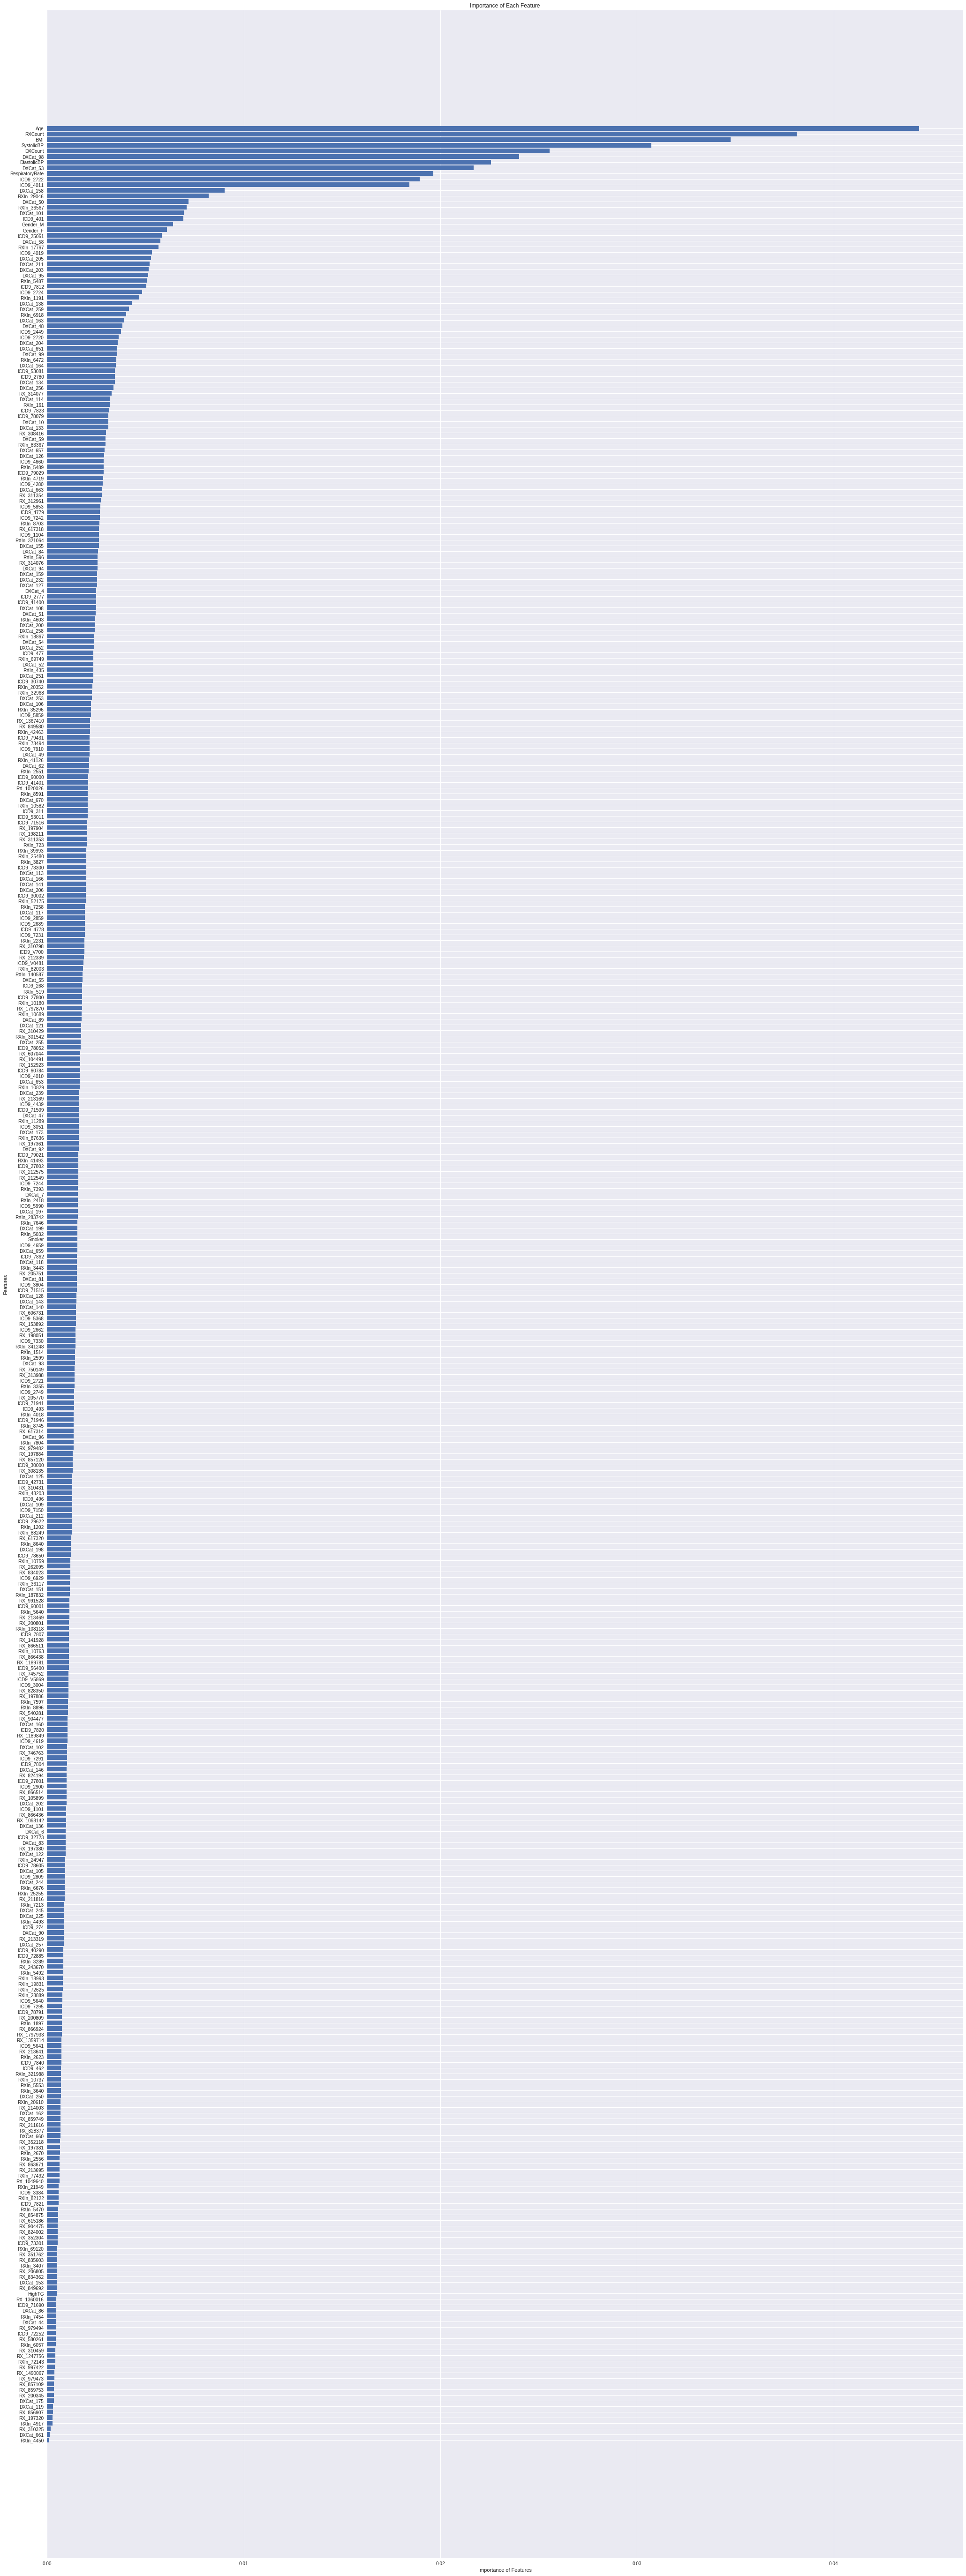

In [0]:
# Stolen from http://bigdata-madesimple.com/dealing-with-unbalanced-class-svm-random-forest-and-decision-tree-in-python/
imp = rfc.feature_importances_
names = X.columns

imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of Features')
plt.ylabel('Features')
plt.title('Importance of Each Feature')

fig = plt.gcf()
fig.set_size_inches(35, 100)

In [0]:
!pip install imbalanced-learn

    100% |████████████████████████████████| 153kB 3.5MB/s 


In [0]:
# A host of Scikit-learn models
#from sklearn.svm import SVC, LinearSVC
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.kernel_approximation import Nystroem
#from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
#from imblearn.ensemble import BalancedBaggingClassifier 
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
#from sklearn.linear_model import SGDClassifier
#from sklearn.svm import LinearSVC

def get_models():
    """Generate a library of base learners."""
    #nb = GaussianNB()
    #svc = SVC(kernel='linear',
    #        class_weight='balanced', # penalize
    #        probability=True)
#     svc = SVC(C=100, 
#             class_weight='balanced', # penalize
#             probability=True)
    #svc = SVC(C=100, probability=True)
    #knn = KNeighborsClassifier(n_neighbors=3)
    #lr = LogisticRegression(C=100, random_state=seed)
    #lr = LogisticRegression(class_weight='balanced', random_state=seed)
    #lr = LogisticRegression()
    #nn = MLPClassifier()
    #gb = GradientBoostingClassifier()
    #rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=seed)
    #rf = RandomForestClassifier(n_estimators=10, max_features=3, class_weight='balanced', random_state=seed)
    #rf = RandomForestClassifier(class_weight='balanced', random_state=seed)
    #rf = RandomForestClassifier()
    #gpc = GaussianProcessClassifier()
    #dtc = DecisionTreeClassifier()
    #abc = AdaBoostClassifier()
    #qdc = QuadraticDiscriminantAnalysis()
    #sgd = SGDClassifier(loss="log")
    #lsvc= LinearSVC()
    
    lr = LogisticRegression(C=100, random_state=seed)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=seed)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=seed)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=seed)
    
    models = {# 'svm': svc,
              #'knn': knn,
              #'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              #'gausian process': gpc,
              #'decision tree': dtc,
              #'ada boost': abc,
              #'discrim analysis':qdc,
              #'sgd': sgd,
              #'lsvc': lsvc   
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_test.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(X_train, y_train)
        P.iloc[:, i] = m.predict_proba(X_test)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [0]:
models = get_models()
P = train_predict(models)
score_models(P, y_test)

Fitting models.
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
mlp-nn                    : 0.785
random forest             : 0.774
gbm                       : 0.835
logistic                  : 0.803
Done.



In [0]:
!pip install mlens

    100% |████████████████████████████████| 235kB 2.9MB/s 


In [0]:
from mlens.ensemble import SuperLearner

base_learners = get_models()
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=seed
)

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=seed,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(X_train, y_train)

# Predict the test set
p_sl = sl.predict_proba(X_test)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(y_test, p_sl[:, 1]))



Fitting 2 layers


[MLENS] backend: threading


Processing layer-1             done | 00:01:40
Processing layer-2             done | 00:00:03
Fit complete                        | 00:01:44

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01

Super Learner ROC-AUC score: 0.839


In [0]:
log_loss(y_test, p_sl)

0.36722013296785366

In [0]:
#http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/
from sklearn.grid_search import GridSearchCV

class EstimatorSelectionHelper:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs    
    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            #d1.items() | d2.items()
            return pd.Series(dict(params.items() | d.items()))
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        #df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)
        #.sort_values(by='col1', ascending=False)
        df = pd.concat(rows, axis=1).T.sort_values(by=sort_by, ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [0]:
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

models1 = { 
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    #'SVC': SVC()
}

params1 = { 
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
#     'SVC': [
#         {'kernel': ['linear'], 'C': [1, 10]},
#         {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
#     ]
}

In [0]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_train, y_train, scoring='f1', n_jobs=-1)

helper1.score_summary(sort_by='min_score')

Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.1s finished


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.7s finished


Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.8s finished


,estimator,min_score,mean_score,max_score,std_score,learning_rate,n_estimators
9,GradientBoostingClassifier,0.413994,0.441453,0.461326,0.020054,1,32
7,GradientBoostingClassifier,0.411498,0.423666,0.443452,0.0141139,0.8,32
5,AdaBoostClassifier,0.402576,0.414579,0.42921,0.0110309,NaN,32
6,GradientBoostingClassifier,0.401264,0.405625,0.411765,0.00446767,0.8,16
8,GradientBoostingClassifier,0.379471,0.415753,0.445428,0.0273289,1,16
4,AdaBoostClassifier,0.370497,0.397623,0.41543,0.0194911,NaN,16
3,RandomForestClassifier,0.325843,0.335688,0.343511,0.00735367,NaN,32
0,ExtraTreesClassifier,0.318584,0.339298,0.358885,0.0164721,NaN,16
2,RandomForestClassifier,0.312849,0.319586,0.325758,0.00528495,NaN,16
1,ExtraTreesClassifier,0.311355,0.344544,0.370629,0.0247144,NaN,32


In [0]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

def modelfit(alg, X_train, y_train, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X_train.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        fig = plt.gcf()
        fig.set_size_inches(100, 35)        


Model Report
Accuracy : 0.857
AUC Score (Train): 0.888126
CV Score : Mean - 0.8199274 | Std - 0.007398494 | Min - 0.8121534 | Max - 0.8340602


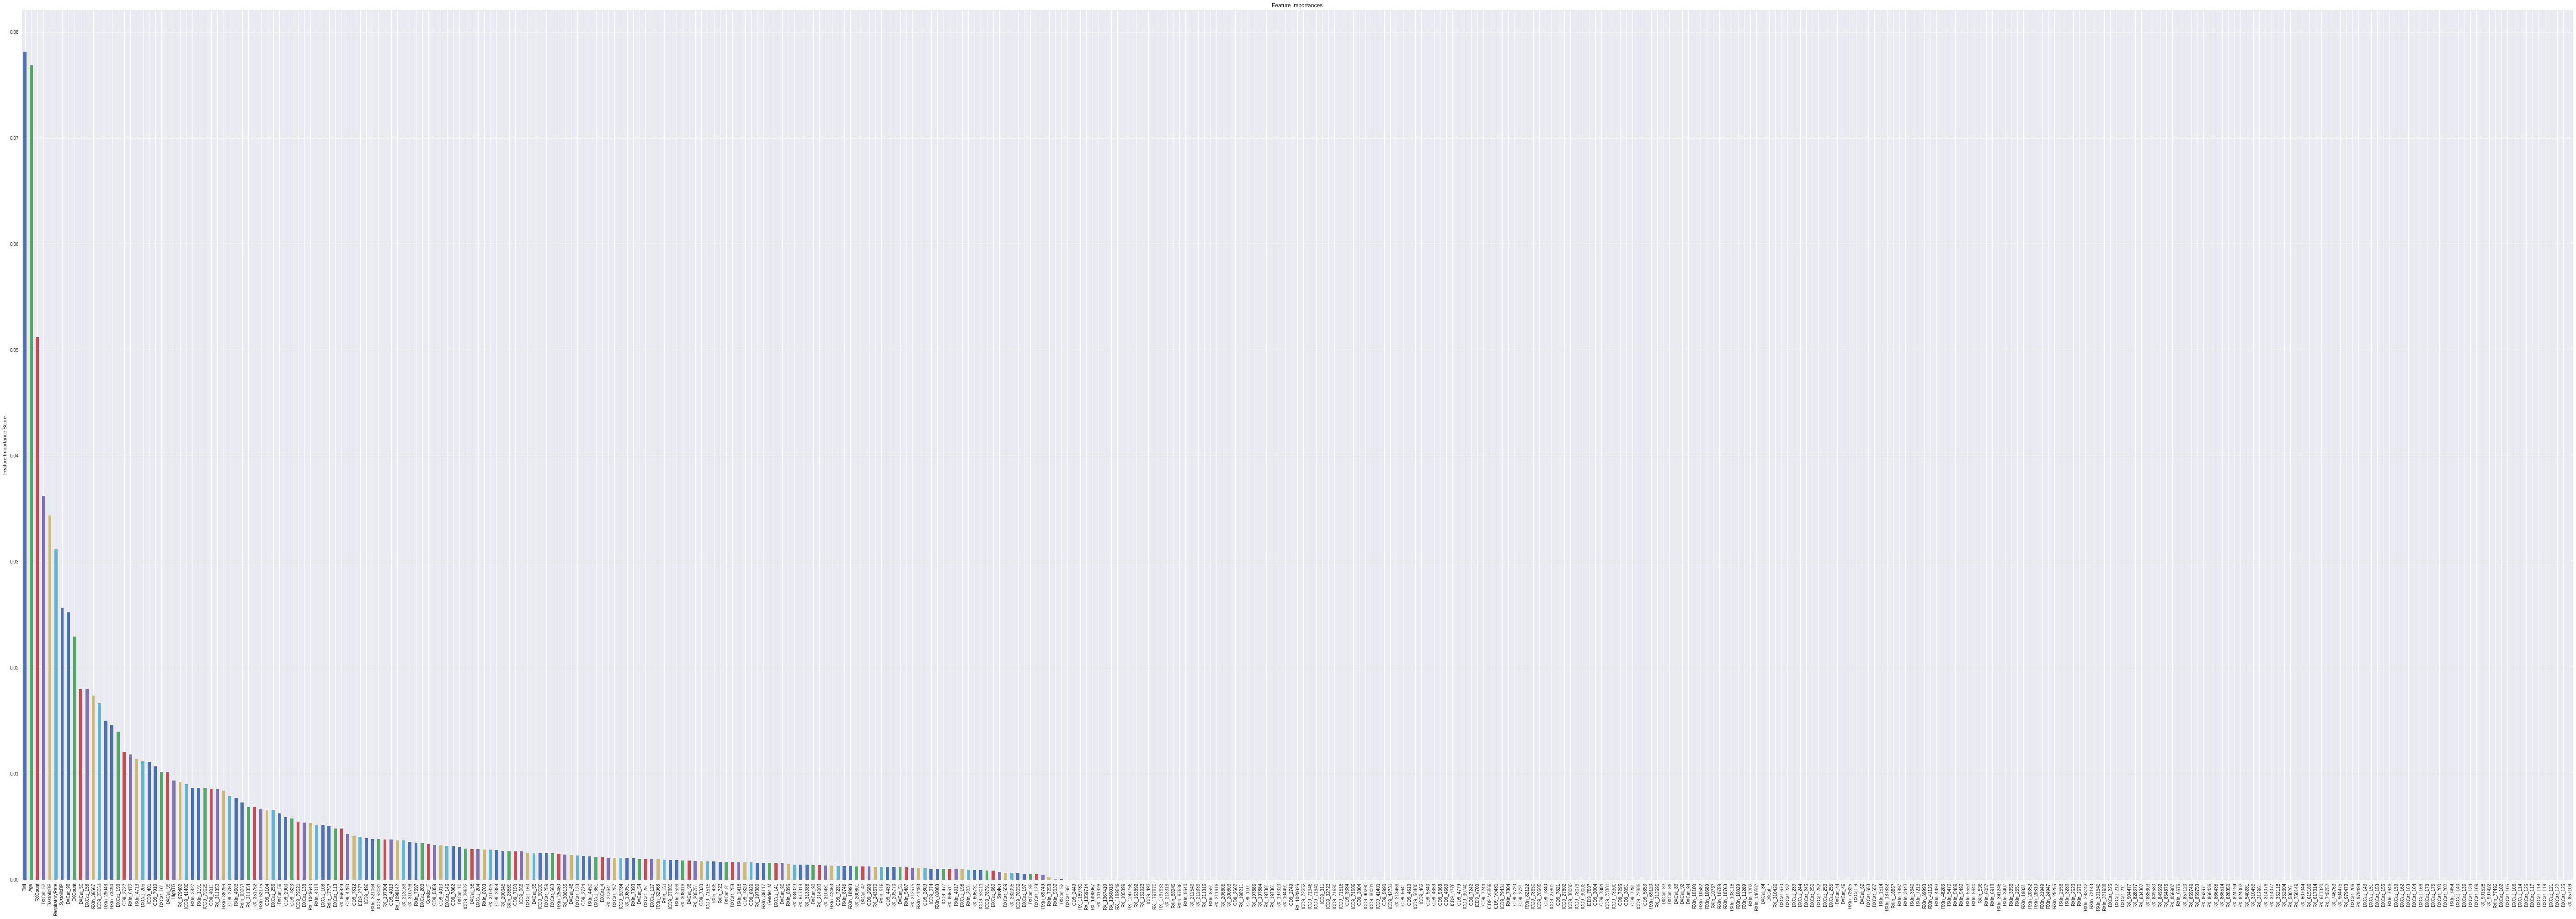

In [0]:
#Choose all predictors except target & IDcols
gbm0 = GradientBoostingClassifier(random_state=seed)
modelfit(gbm0, X_train, y_train)

In [0]:
y_pred = gbm0.predict(X_test)
log_loss(y_test, y_pred)

5.398233074379398

In [0]:
#Choose all predictors except target & IDcols
param_test1 = {'n_estimators': list(range(20,201,10))}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.175, min_samples_split=500, min_samples_leaf=50, max_depth=8, max_features='sqrt', subsample=0.8, random_state=seed), param_grid = param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.80193, std: 0.00969, params: {'n_estimators': 20},
  mean: 0.80759, std: 0.00812, params: {'n_estimators': 30},
  mean: 0.80879, std: 0.00680, params: {'n_estimators': 40},
  mean: 0.80920, std: 0.00615, params: {'n_estimators': 50},
  mean: 0.81048, std: 0.00562, params: {'n_estimators': 60},
  mean: 0.81057, std: 0.00557, params: {'n_estimators': 70},
  mean: 0.81004, std: 0.00547, params: {'n_estimators': 80},
  mean: 0.80991, std: 0.00478, params: {'n_estimators': 90},
  mean: 0.80854, std: 0.00520, params: {'n_estimators': 100},
  mean: 0.80807, std: 0.00522, params: {'n_estimators': 110},
  mean: 0.80665, std: 0.00470, params: {'n_estimators': 120},
  mean: 0.80659, std: 0.00351, params: {'n_estimators': 130},
  mean: 0.80652, std: 0.00332, params: {'n_estimators': 140},
  mean: 0.80556, std: 0.00278, params: {'n_estimators': 150},
  mean: 0.80631, std: 0.00294, params: {'n_estimators': 160},
  mean: 0.80526, std: 0.00239, params: {'n_estimators': 170},
  mean: 0.80506,

In [0]:
param_test2 = {'max_depth':list(range(5,16,2)), 'min_samples_split':list(range(200,1001,200))}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.175, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=seed), param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.82514, std: 0.00639, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.82660, std: 0.00623, params: {'max_depth': 5, 'min_samples_split': 400},
  mean: 0.82602, std: 0.00709, params: {'max_depth': 5, 'min_samples_split': 600},
  mean: 0.82877, std: 0.00691, params: {'max_depth': 5, 'min_samples_split': 800},
  mean: 0.82728, std: 0.00586, params: {'max_depth': 5, 'min_samples_split': 1000},
  mean: 0.82401, std: 0.00454, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.82552, std: 0.00482, params: {'max_depth': 7, 'min_samples_split': 400},
  mean: 0.82559, std: 0.00657, params: {'max_depth': 7, 'min_samples_split': 600},
  mean: 0.82537, std: 0.00657, params: {'max_depth': 7, 'min_samples_split': 800},
  mean: 0.82671, std: 0.00753, params: {'max_depth': 7, 'min_samples_split': 1000},
  mean: 0.82138, std: 0.00772, params: {'max_depth': 9, 'min_samples_split': 200},
  mean: 0.82485, std: 0.00558, params: {'max_depth': 9, 'min_samples_split': 400},
  

Start here!

In [0]:
param_test3 = {'min_samples_split':list(range(1000,2100,200)), 'min_samples_leaf':list(range(1,71,10))}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.175, n_estimators=80, max_depth=7, min_samples_split=600, max_features='sqrt', subsample=0.8, random_state=seed), param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.82671, std: 0.00753, params: {'min_samples_leaf': 1, 'min_samples_split': 1000},
  mean: 0.82892, std: 0.00579, params: {'min_samples_leaf': 1, 'min_samples_split': 1200},
  mean: 0.83059, std: 0.00559, params: {'min_samples_leaf': 1, 'min_samples_split': 1400},
  mean: 0.82779, std: 0.00689, params: {'min_samples_leaf': 1, 'min_samples_split': 1600},
  mean: 0.82873, std: 0.00547, params: {'min_samples_leaf': 1, 'min_samples_split': 1800},
  mean: 0.82830, std: 0.00558, params: {'min_samples_leaf': 1, 'min_samples_split': 2000},
  mean: 0.82751, std: 0.00373, params: {'min_samples_leaf': 11, 'min_samples_split': 1000},
  mean: 0.82973, std: 0.00736, params: {'min_samples_leaf': 11, 'min_samples_split': 1200},
  mean: 0.82839, std: 0.00580, params: {'min_samples_leaf': 11, 'min_samples_split': 1400},
  mean: 0.82705, std: 0.00559, params: {'min_samples_leaf': 11, 'min_samples_split': 1600},
  mean: 0.82702, std: 0.00500, params: {'min_samples_leaf': 11, 'min_samples_split': 1


Model Report
Accuracy : 0.8527
AUC Score (Train): 0.882165
CV Score : Mean - 0.8305878 | Std - 0.005594413 | Min - 0.8216448 | Max - 0.8393321


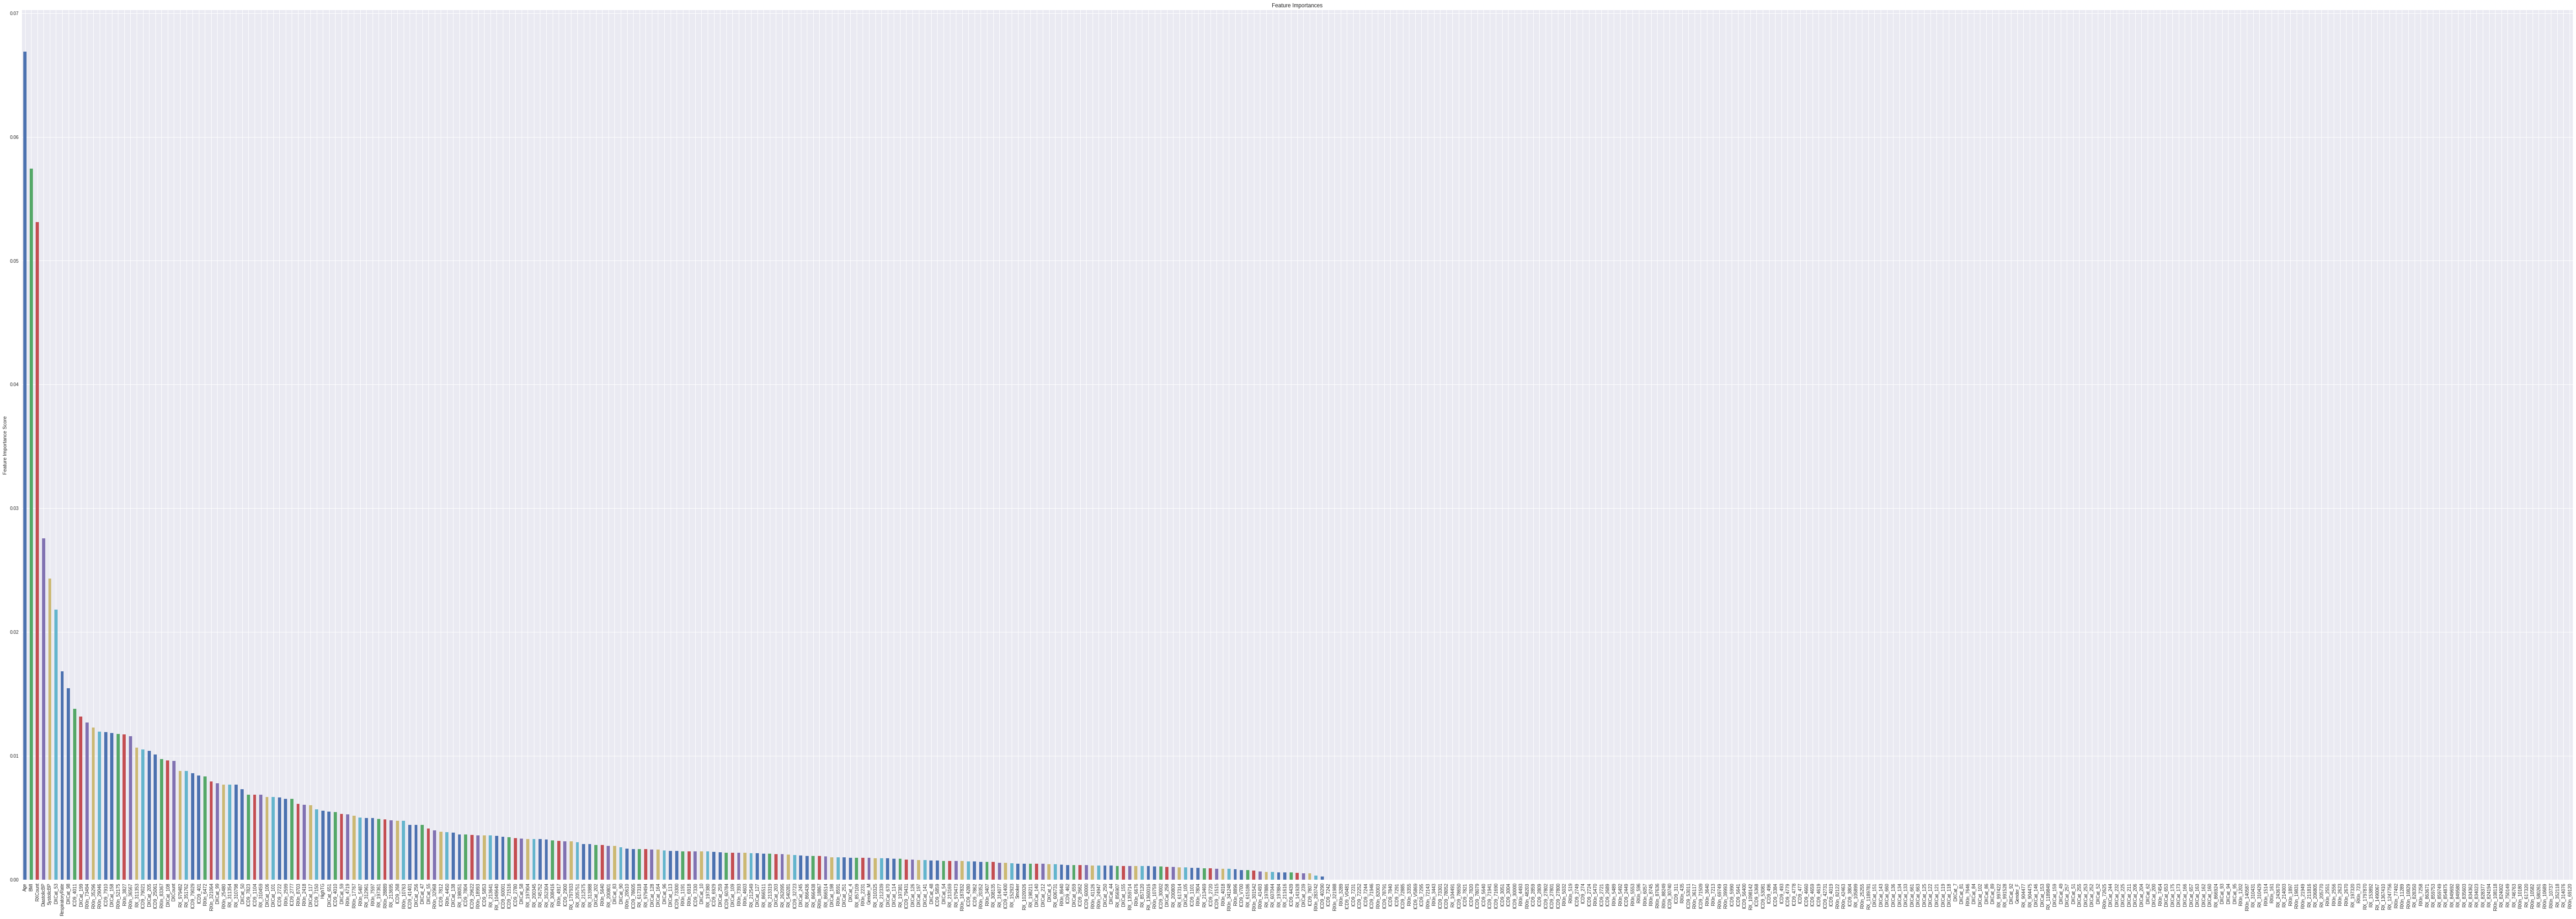

In [0]:
modelfit(gsearch3.best_estimator_, X_train, y_train)

In [0]:
param_test4 = {'max_features':list(range(7,20,2))}
#{'min_samples_leaf': 11, 'min_samples_split': 1800},
#'min_samples_leaf': 11, 'min_samples_split': 1400
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.175, n_estimators=80, max_depth=7, min_samples_leaf=11, min_samples_split=1400, subsample=0.8, random_state=seed), param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.82279, std: 0.00572, params: {'max_features': 7},
  mean: 0.82461, std: 0.00630, params: {'max_features': 9},
  mean: 0.82539, std: 0.00628, params: {'max_features': 11},
  mean: 0.82619, std: 0.00555, params: {'max_features': 13},
  mean: 0.82514, std: 0.00564, params: {'max_features': 15},
  mean: 0.82603, std: 0.00739, params: {'max_features': 17},
  mean: 0.82636, std: 0.00444, params: {'max_features': 19}],
 {'max_features': 19},
 0.8263589336847644)

In [0]:
#gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.14, n_estimators=70, max_features='sqrt', subsample=0.8, random_state=seed), 

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.175, n_estimators=80, max_depth=7, min_samples_leaf=11, min_samples_split=1400,  max_features=19, subsample=0.8, random_state=seed), param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.82672, std: 0.00457, params: {'subsample': 0.6},
  mean: 0.82818, std: 0.00526, params: {'subsample': 0.7},
  mean: 0.82910, std: 0.00653, params: {'subsample': 0.75},
  mean: 0.82636, std: 0.00444, params: {'subsample': 0.8},
  mean: 0.82649, std: 0.00376, params: {'subsample': 0.85},
  mean: 0.82628, std: 0.00568, params: {'subsample': 0.9}],
 {'subsample': 0.75},
 0.8291011570714429)


Model Report
Accuracy : 0.8494
AUC Score (Train): 0.881678
CV Score : Mean - 0.8291012 | Std - 0.006533625 | Min - 0.820498 | Max - 0.8384872


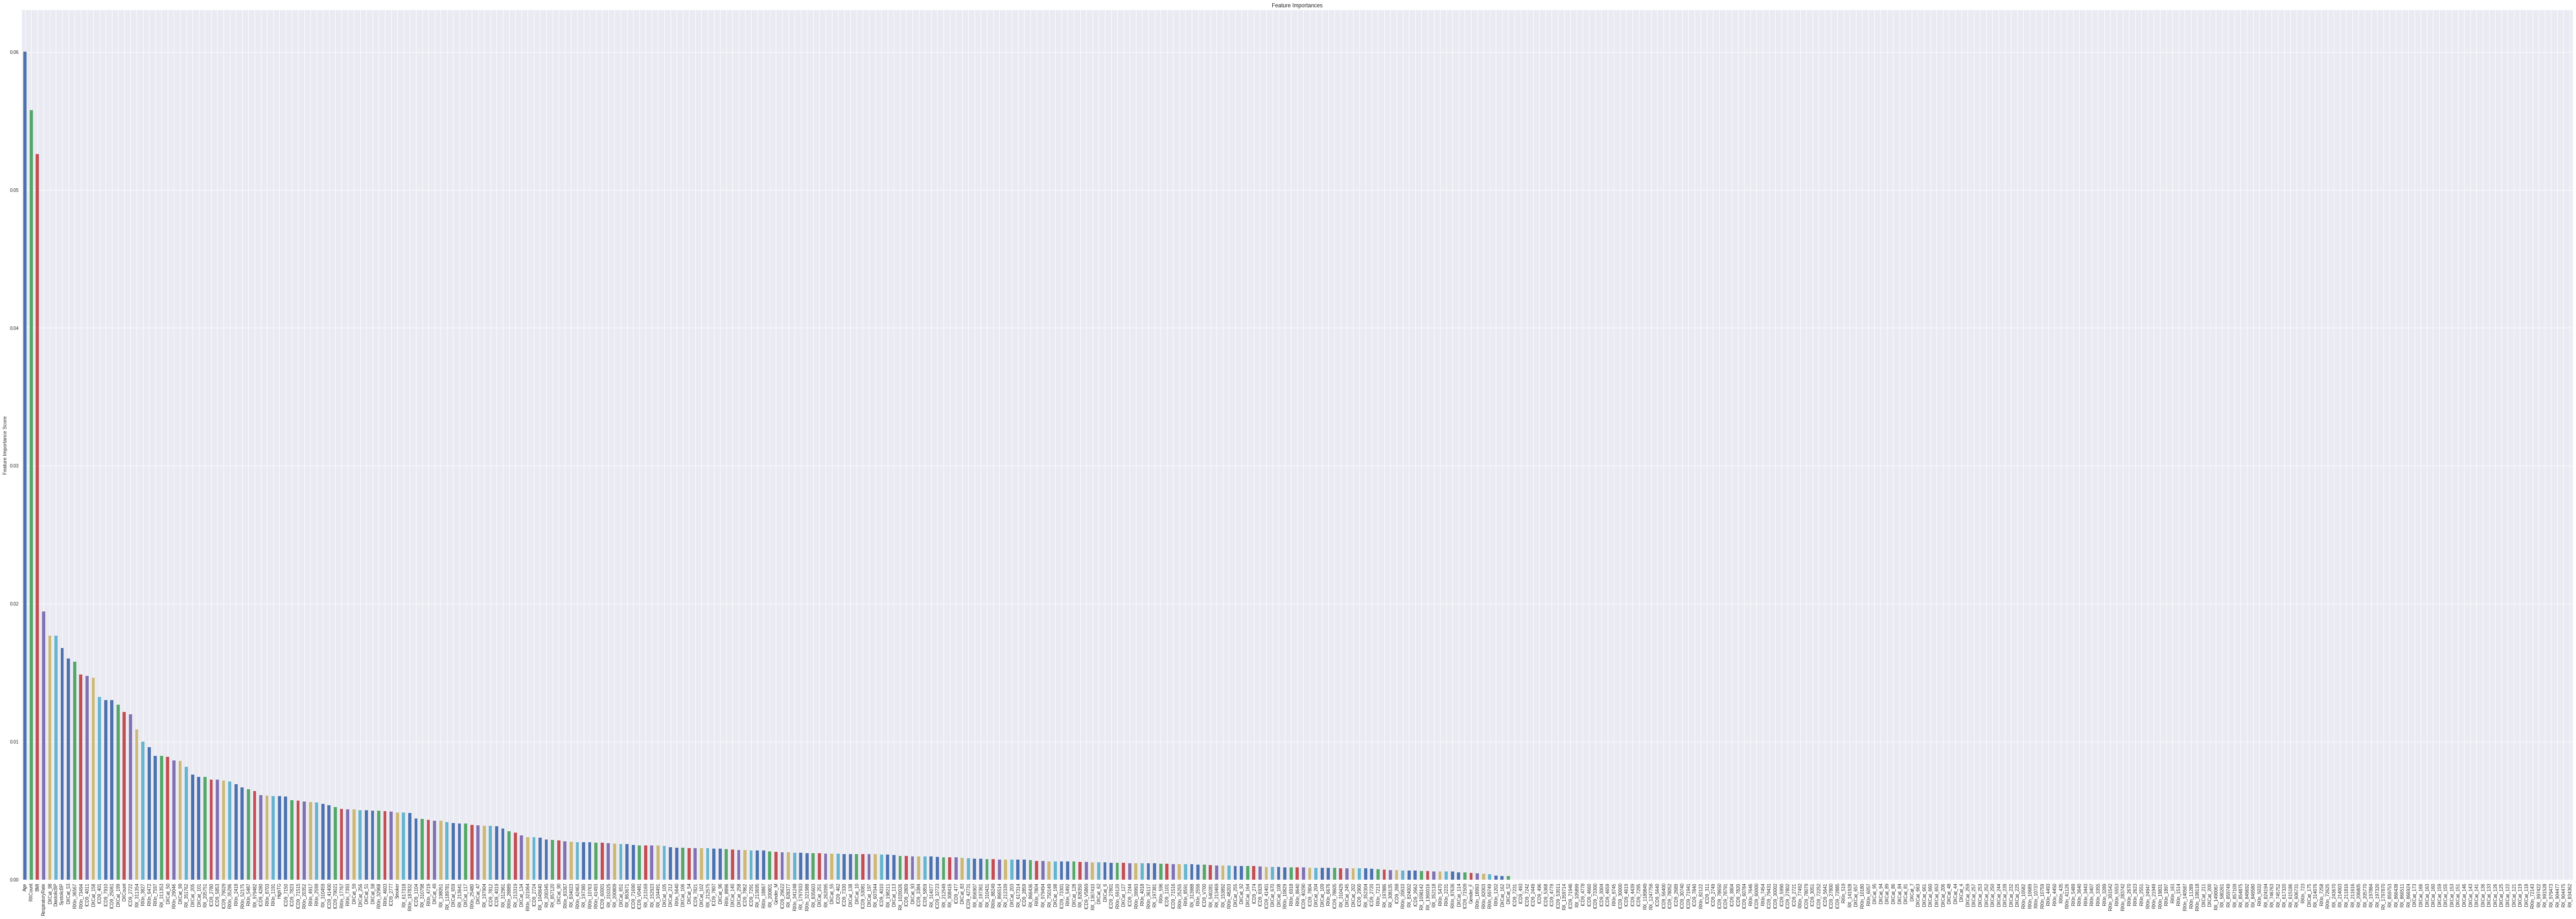

In [0]:
modelfit(gsearch5.best_estimator_, X_train, y_train)


Model Report
Accuracy : 0.8508
AUC Score (Train): 0.886257
CV Score : Mean - 0.8310051 | Std - 0.005439338 | Min - 0.8238631 | Max - 0.8399032


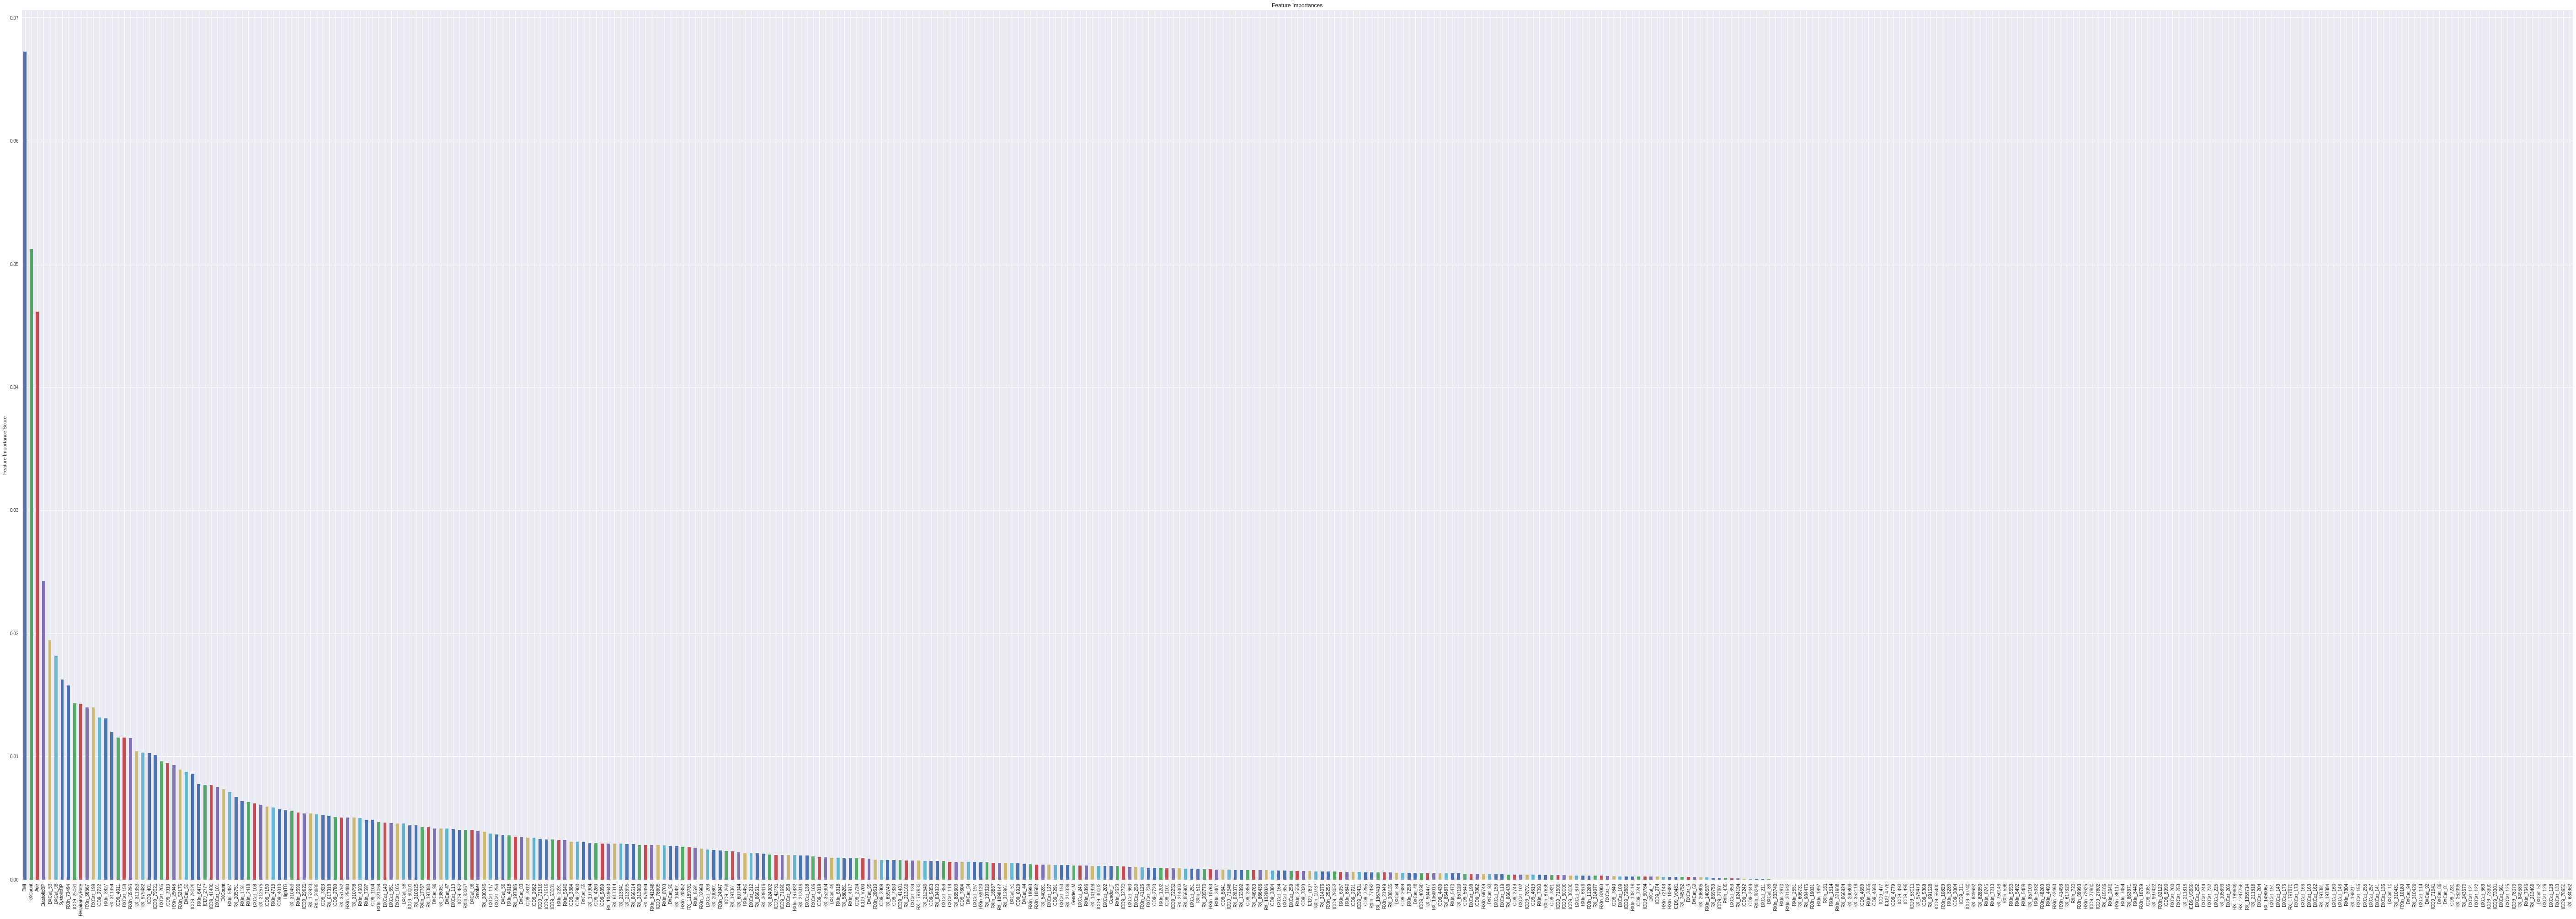

In [0]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.0875, n_estimators=160, max_depth=7, min_samples_split=1400, min_samples_leaf=11, max_features=19, subsample=0.85, random_state=seed)
modelfit(gbm_tuned_1, X_train, y_train)


Model Report
Accuracy : 0.8522
AUC Score (Train): 0.888675
CV Score : Mean - 0.8319472 | Std - 0.005729651 | Min - 0.8260532 | Max - 0.8416258


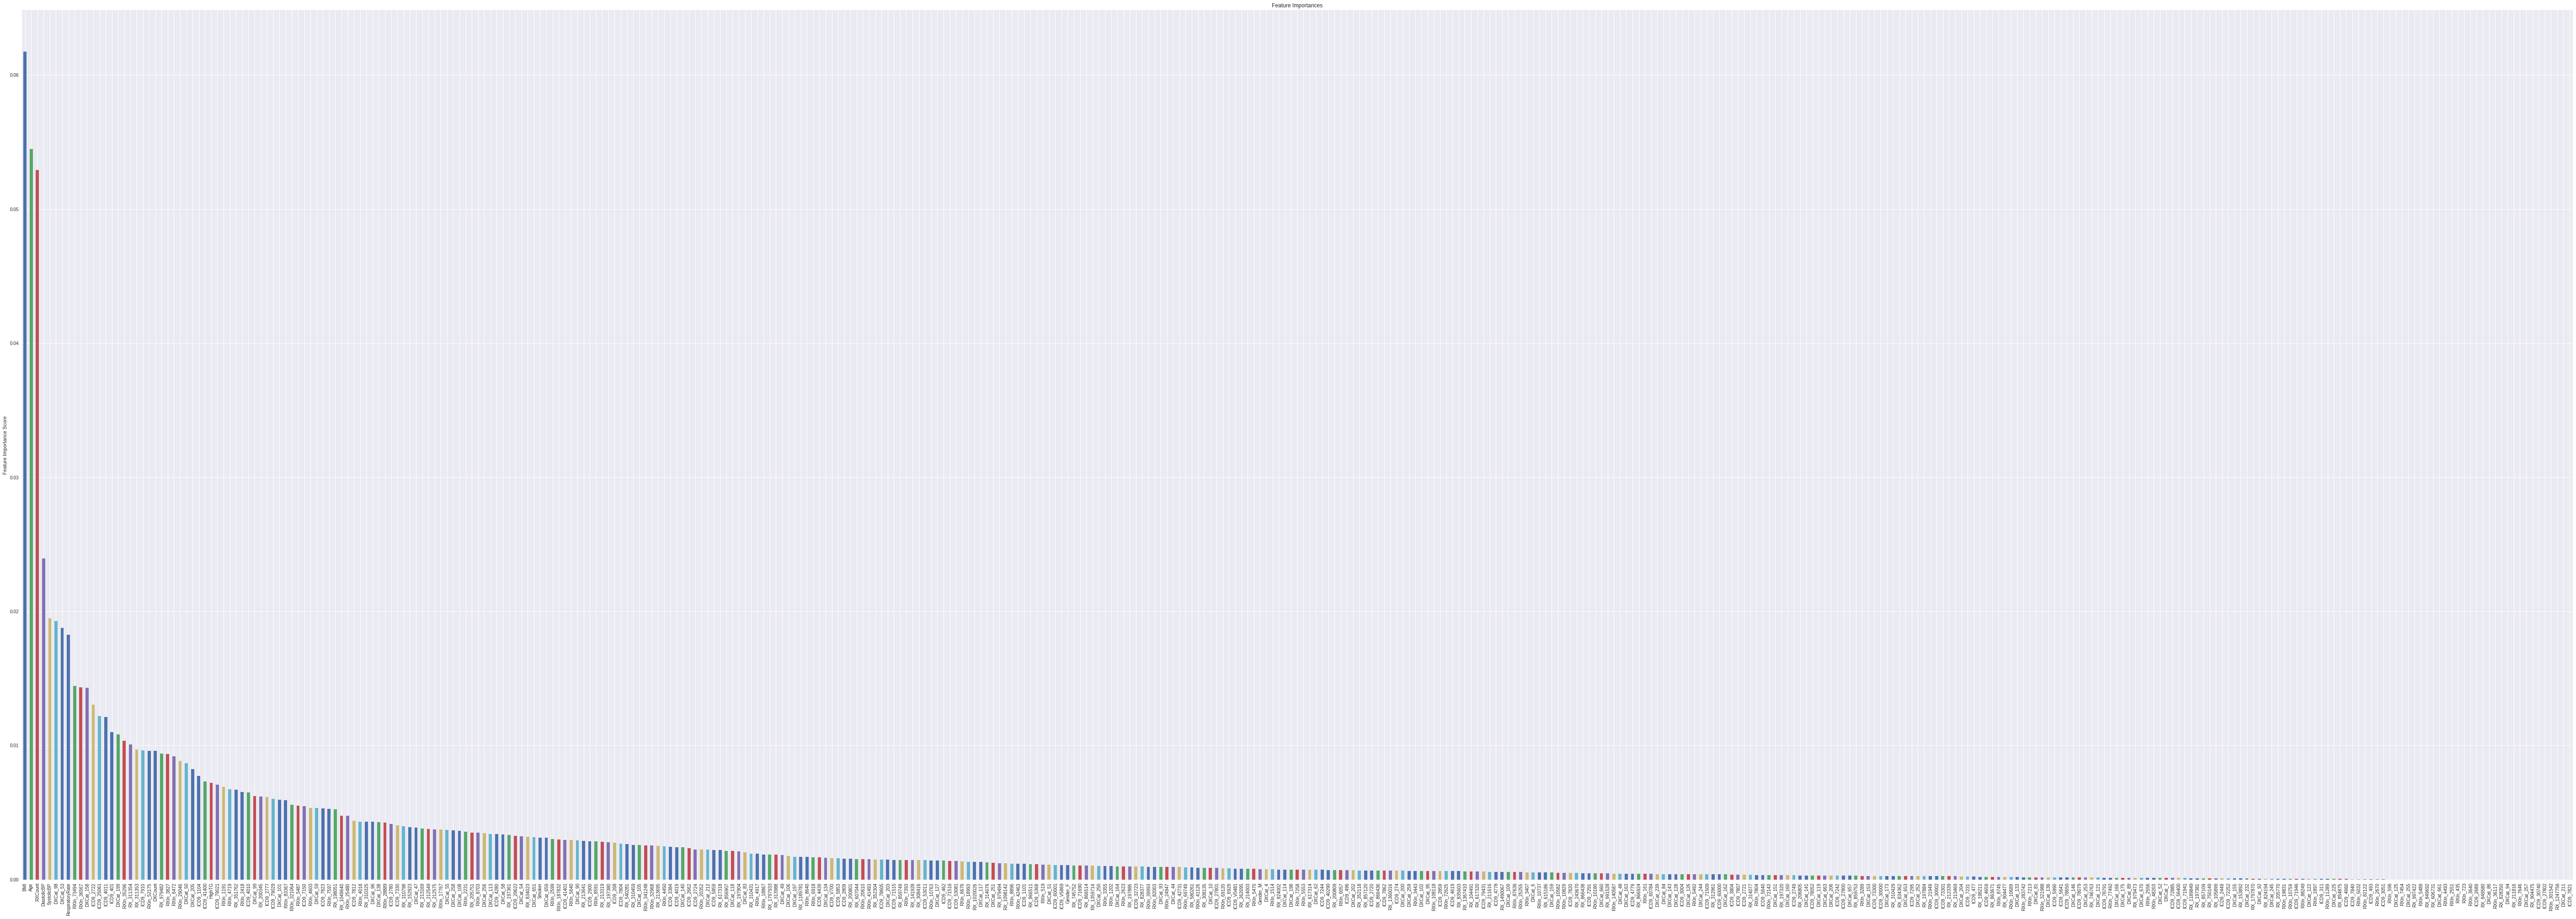

In [0]:
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.0175, n_estimators=800, max_depth=7, min_samples_split=1400, min_samples_leaf=11, max_features=19, subsample=0.85, random_state=seed)
modelfit(gbm_tuned_2, X_train, y_train)


Model Report
Accuracy : 0.8517
AUC Score (Train): 0.889665
CV Score : Mean - 0.8321559 | Std - 0.005455537 | Min - 0.8258934 | Max - 0.8409604


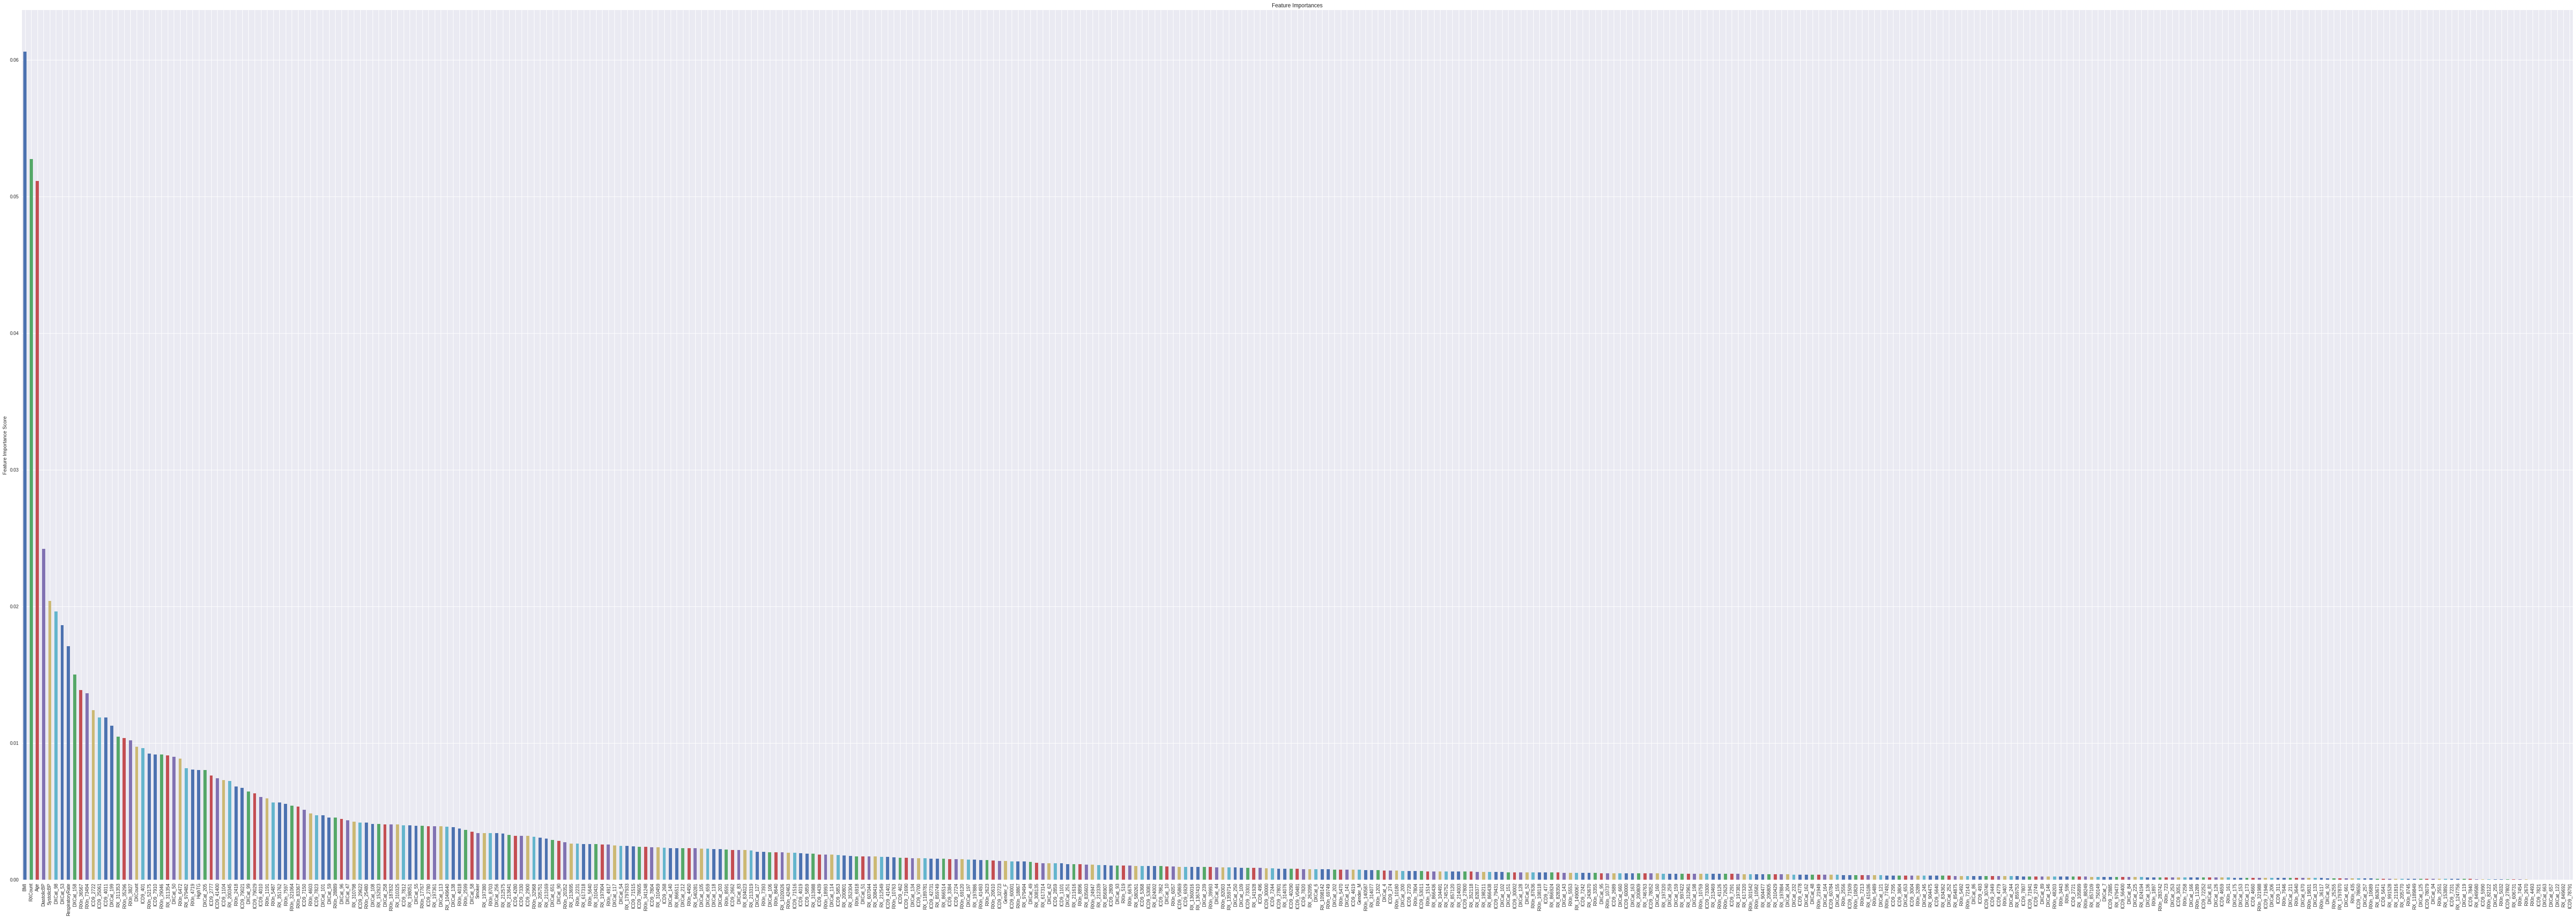

In [0]:
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.00875, n_estimators=1600, max_depth=7, min_samples_split=1400, min_samples_leaf=11, max_features=19, subsample=0.85, random_state=seed)
modelfit(gbm_tuned_3, X_train, y_train)


Model Report
Accuracy : 0.8541
AUC Score (Train): 0.893083
CV Score : Mean - 0.8320632 | Std - 0.005171561 | Min - 0.8260814 | Max - 0.8403562


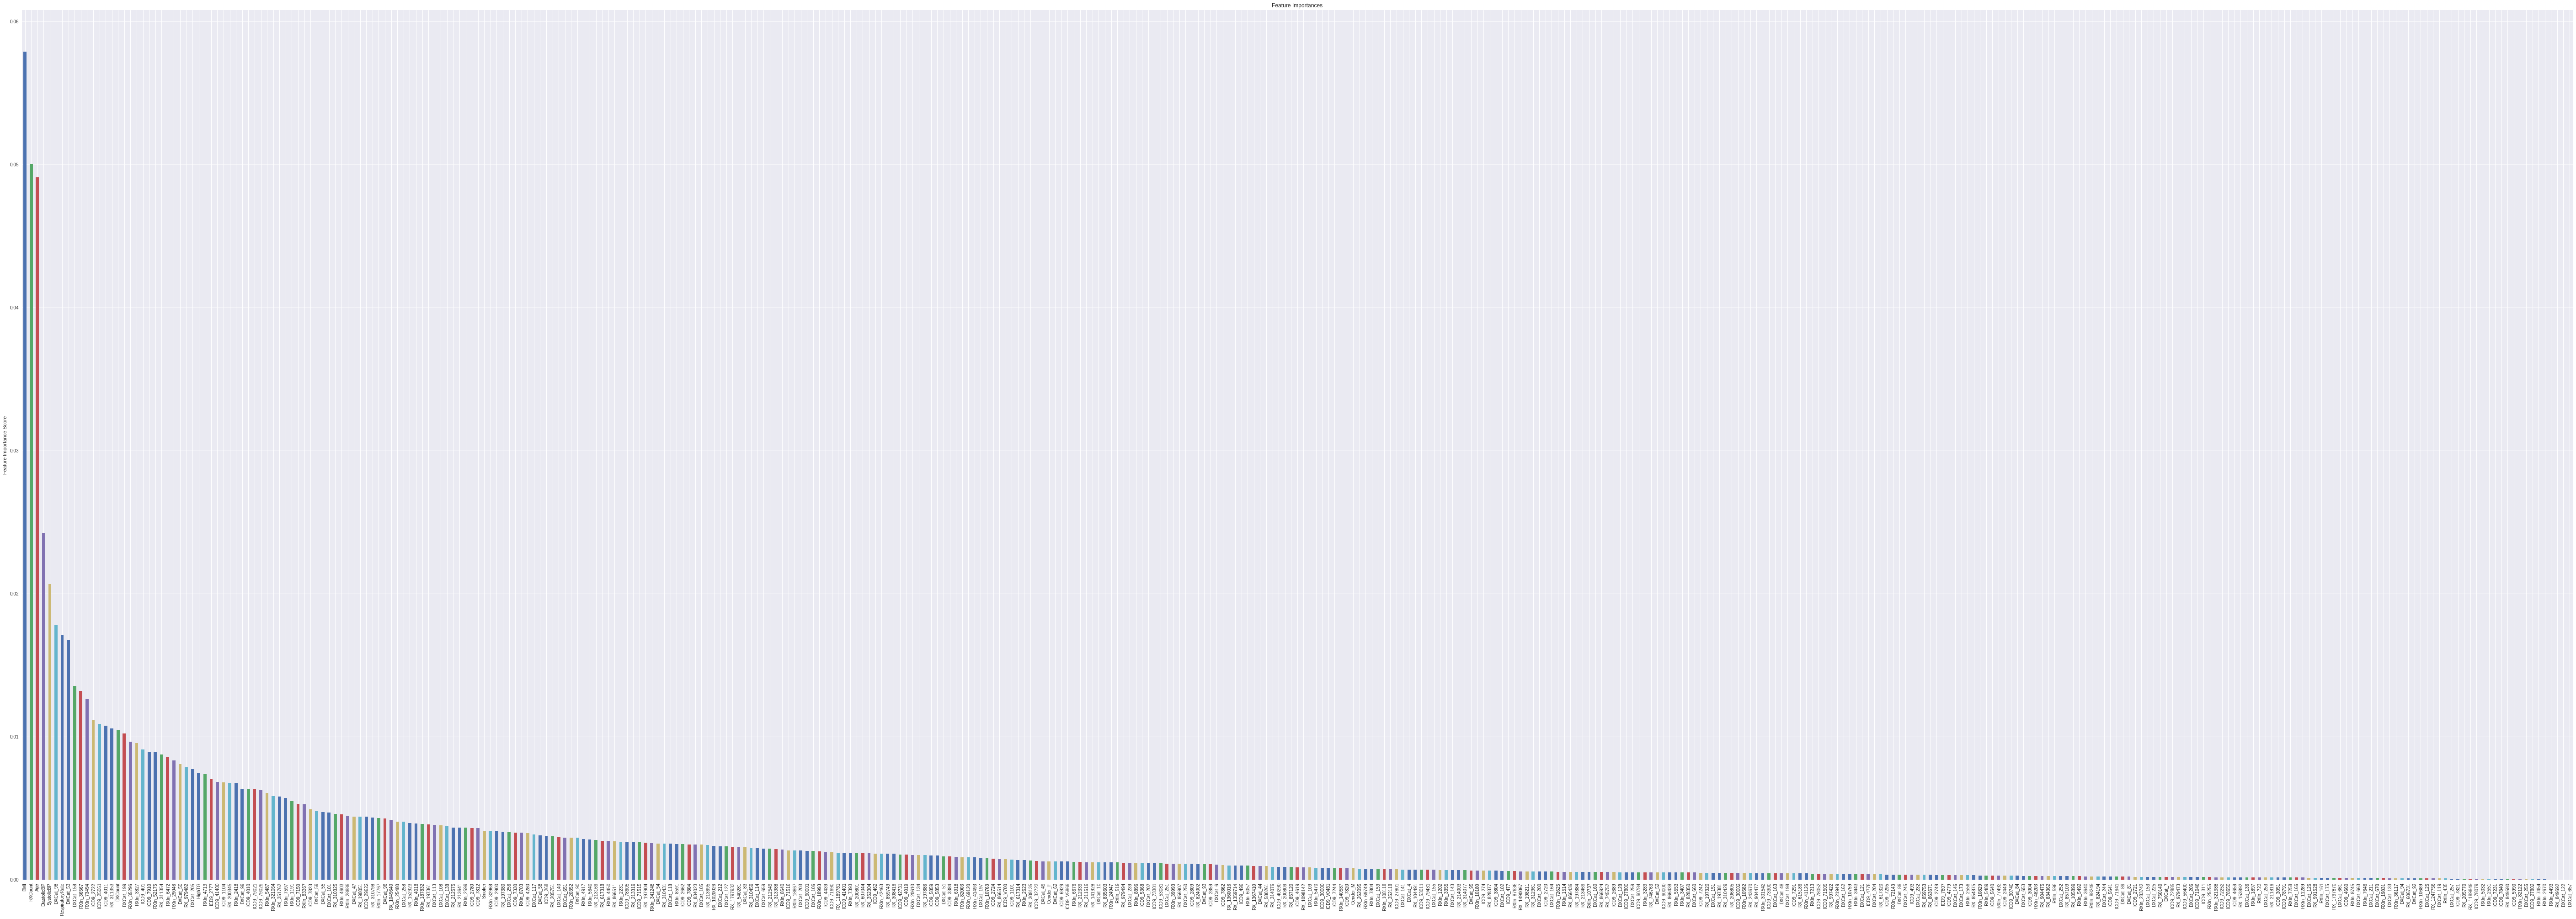

In [0]:
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.00875, n_estimators=1800, max_depth=7, min_samples_split=1400, min_samples_leaf=11, max_features=19, subsample=0.85, random_state=seed)
modelfit(gbm_tuned_4, X_train, y_train)


Model Report
Accuracy : 0.8579
AUC Score (Train): 0.896190
CV Score : Mean - 0.8316973 | Std - 0.005092331 | Min - 0.8257054 | Max - 0.8398418


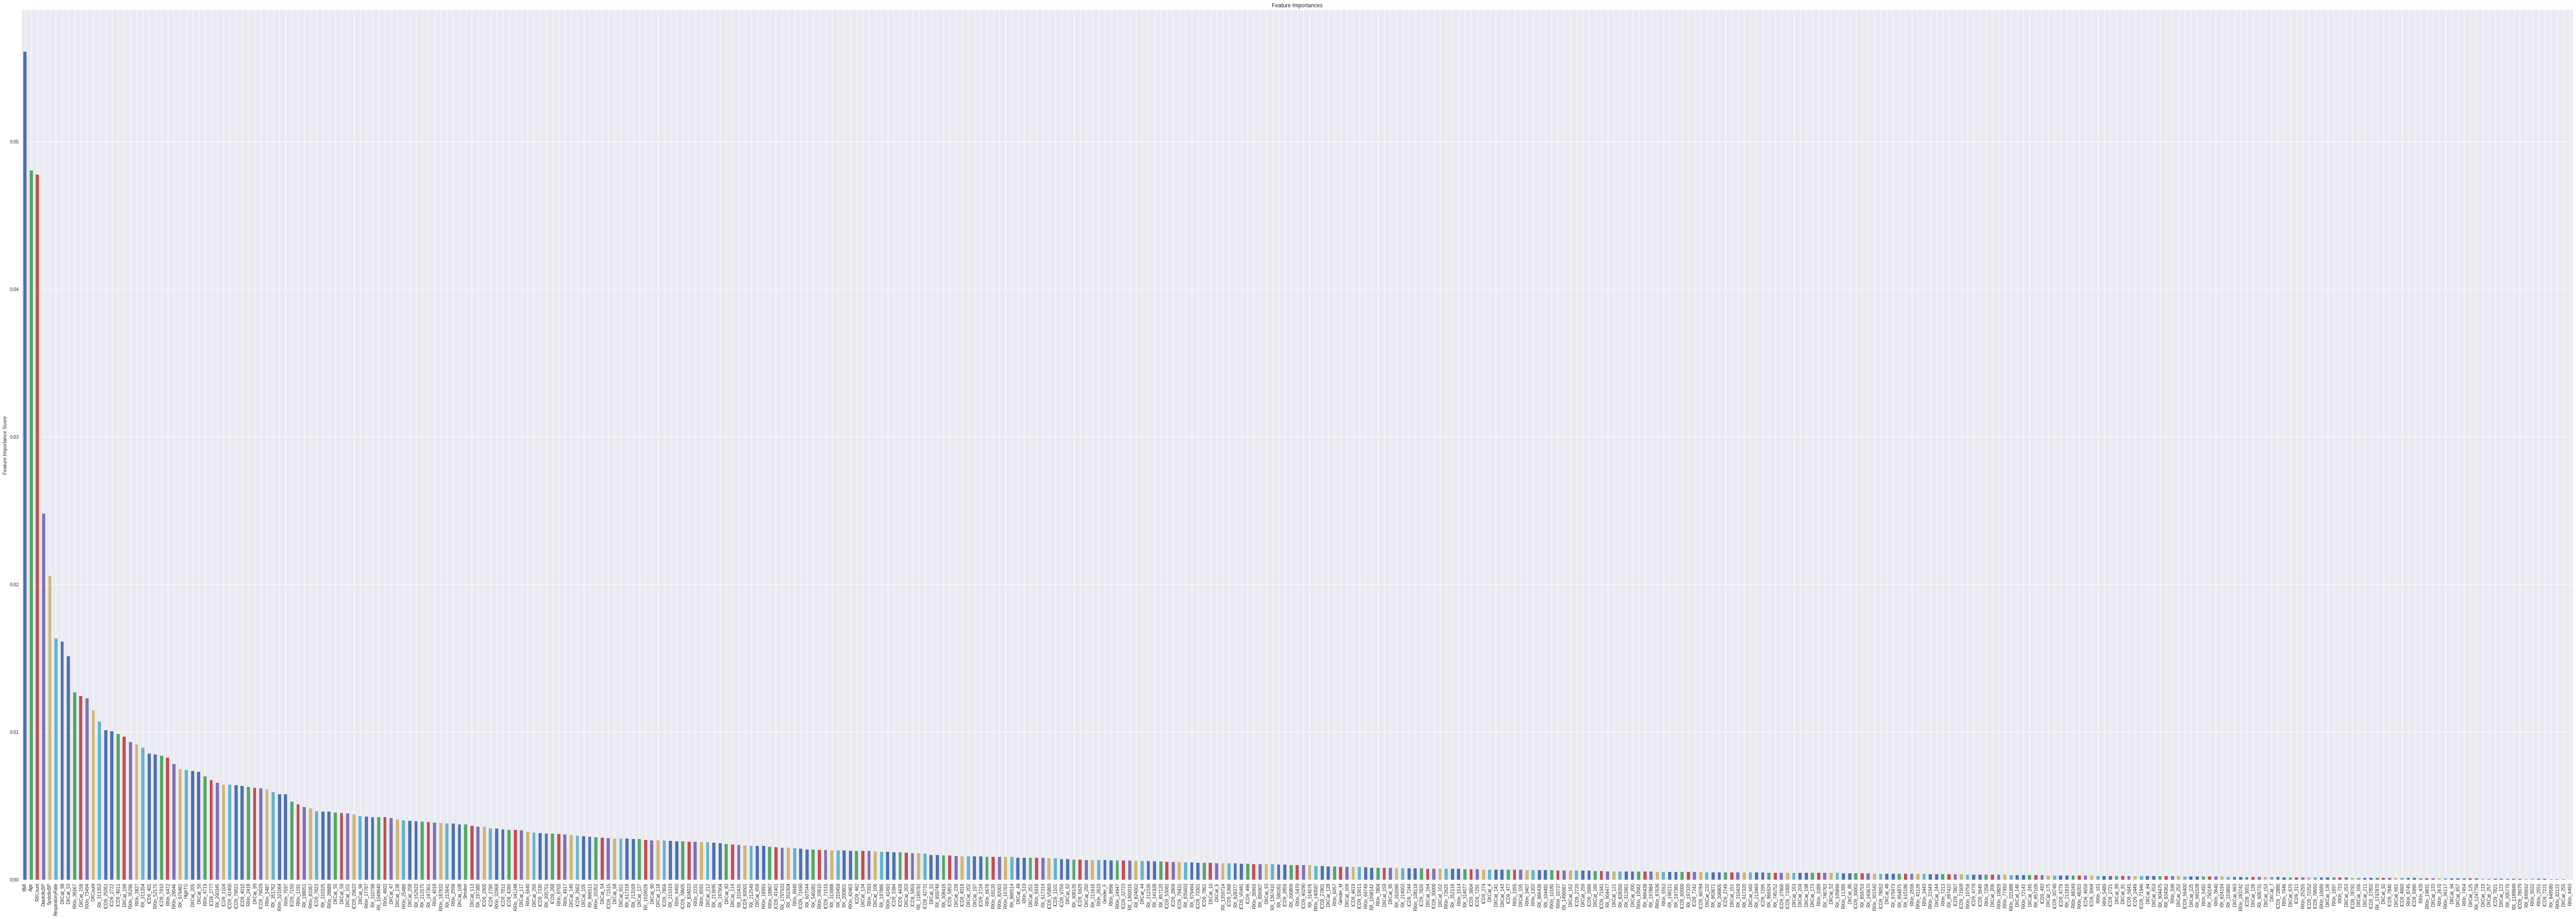

In [0]:
gbm_tuned_5 = GradientBoostingClassifier(learning_rate=0.00875, n_estimators=2000, max_depth=7, min_samples_split=1400, min_samples_leaf=11, max_features=19, subsample=0.85, random_state=seed)
modelfit(gbm_tuned_5, X_train, y_train)

In [0]:
y_pred = gbm_tuned_5.predict(X_test)
log_loss(y_test, y_pred)

5.593655282799002

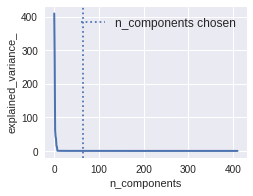

In [0]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 64]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In [0]:
!pip install -q keras

In [0]:
patients = processPatientTranscripts(patientTranscripts, limit=int(1e6))

y = patients[['dmIndicator']].values.ravel()
# PreDB, FhxDM, HighTG, CC

X = patients.drop(['dmIndicator', 'AgeGroup', 'Obese', 'BMICategory', 'BPCategory', 'HT', 'HeavySmoker', 'PhysicianSpecialty', 'BMI'], 1)
X = pd.concat([X.drop('ICD9s', 1), X['ICD9s'].str.get_dummies().add_prefix('ICD9_')], 1)
X = pd.concat([X.drop('RXs', 1), X['RXs'].str.get_dummies().add_prefix('RX_')], 1)
X = pd.concat([X.drop('DXCats', 1), X['DXCats'].str.get_dummies().add_prefix('DXCat_')], 1)
X = pd.concat([X.drop('RXIns', 1), X['RXIns'].str.get_dummies().add_prefix('RXIn_')], 1)
X = pd.get_dummies(X)
X.T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [0]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

In [0]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
from keras.layers import BatchNormalization, Dropout

Using TensorFlow backend.


In [0]:
input_shape = X_train.shape[1]

In [0]:
model = Sequential()
model.add(Dense(16, input_shape=(input_shape,)))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dropout(.5, seed=seed))
model.add(Dense(8, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(.5, seed=seed))
model.add(Dense(1))
model.add(Activation('sigmoid'))
#model.add(BatchNormalization())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1);

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy = {:.2f}".format(accuracy))

Epoch 1/100
5656/5656 [==============================] - 4s 630us/step - loss: 0.9559 - acc: 0.7219
Epoch 2/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.9894 - acc: 0.7707
Epoch 3/100
5656/5656 [==============================] - 3s 514us/step - loss: 0.9453 - acc: 0.7765
Epoch 4/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.8086 - acc: 0.8016
Epoch 5/100
5656/5656 [==============================] - 3s 514us/step - loss: 0.7034 - acc: 0.8064
Epoch 6/100
5056/5656 [=========================>....] - ETA: 0s - loss: 0.6240 - acc: 0.8151

5656/5656 [==============================] - 3s 514us/step - loss: 0.6150 - acc: 0.8145
Epoch 7/100
5656/5656 [==============================] - 3s 517us/step - loss: 0.4971 - acc: 0.8317
Epoch 8/100
5656/5656 [==============================] - 3s 511us/step - loss: 0.4376 - acc: 0.8368
Epoch 9/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.4000 - acc: 0.8449
Epoch 10/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.3730 - acc: 0.8492
Epoch 11/100
5656/5656 [==============================] - 3s 501us/step - loss: 0.3362 - acc: 0.8586
Epoch 12/100
 992/5656 [====>.........................] - ETA: 2s - loss: 0.3249 - acc: 0.8478

5656/5656 [==============================] - 3s 506us/step - loss: 0.3110 - acc: 0.8688
Epoch 13/100
5656/5656 [==============================] - 3s 509us/step - loss: 0.2950 - acc: 0.8722
Epoch 14/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.2760 - acc: 0.8808
Epoch 15/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.2498 - acc: 0.8923
Epoch 16/100
5656/5656 [==============================] - 3s 531us/step - loss: 0.2443 - acc: 0.8983
Epoch 17/100
5656/5656 [==============================] - 3s 513us/step - loss: 0.2205 - acc: 0.9070


Epoch 18/100
5656/5656 [==============================] - 3s 509us/step - loss: 0.2178 - acc: 0.9086
Epoch 19/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.2065 - acc: 0.9158
Epoch 20/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.1900 - acc: 0.9245
Epoch 21/100
5656/5656 [==============================] - 3s 511us/step - loss: 0.1871 - acc: 0.9254
Epoch 22/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1864 - acc: 0.9257
Epoch 23/100
5216/5656 [==========================>...] - ETA: 0s - loss: 0.1697 - acc: 0.9331

5656/5656 [==============================] - 3s 513us/step - loss: 0.1716 - acc: 0.9319
Epoch 24/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.1686 - acc: 0.9344
Epoch 25/100
5656/5656 [==============================] - 3s 510us/step - loss: 0.1862 - acc: 0.9272
Epoch 26/100
5656/5656 [==============================] - 3s 503us/step - loss: 0.1995 - acc: 0.9185
Epoch 27/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1943 - acc: 0.9183
Epoch 28/100
5656/5656 [==============================] - 3s 517us/step - loss: 0.1816 - acc: 0.9234
Epoch 29/100
 704/5656 [==>...........................] - ETA: 2s - loss: 0.1643 - acc: 0.9361

5656/5656 [==============================] - 3s 515us/step - loss: 0.1692 - acc: 0.9309
Epoch 30/100
5656/5656 [==============================] - 3s 517us/step - loss: 0.1649 - acc: 0.9316
Epoch 31/100
5656/5656 [==============================] - 3s 512us/step - loss: 0.1666 - acc: 0.9316
Epoch 32/100
5656/5656 [==============================] - 3s 503us/step - loss: 0.1744 - acc: 0.9257
Epoch 33/100
5656/5656 [==============================] - 3s 503us/step - loss: 0.1566 - acc: 0.9342
Epoch 34/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.1496 - acc: 0.9395
Epoch 35/100
  32/5656 [..............................] - ETA: 2s - loss: 0.0780 - acc: 0.9688

5656/5656 [==============================] - 3s 508us/step - loss: 0.1587 - acc: 0.9344
Epoch 36/100
5656/5656 [==============================] - 3s 514us/step - loss: 0.1452 - acc: 0.9429
Epoch 37/100
5656/5656 [==============================] - 3s 509us/step - loss: 0.1454 - acc: 0.9415
Epoch 38/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1415 - acc: 0.9399
Epoch 39/100
5656/5656 [==============================] - 3s 509us/step - loss: 0.1316 - acc: 0.9447
Epoch 40/100
5656/5656 [==============================] - 3s 514us/step - loss: 0.1344 - acc: 0.9496
Epoch 41/100
  32/5656 [..............................] - ETA: 2s - loss: 0.1401 - acc: 0.9375

5656/5656 [==============================] - 3s 513us/step - loss: 0.1314 - acc: 0.9463
Epoch 42/100
5656/5656 [==============================] - 3s 503us/step - loss: 0.1434 - acc: 0.9454
Epoch 43/100
5656/5656 [==============================] - 3s 501us/step - loss: 0.1285 - acc: 0.9477
Epoch 44/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.1183 - acc: 0.9556
Epoch 45/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1317 - acc: 0.9459
Epoch 46/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.1314 - acc: 0.9473
Epoch 47/100
 320/5656 [>.............................] - ETA: 2s - loss: 0.1149 - acc: 0.9500

5656/5656 [==============================] - 3s 511us/step - loss: 0.1148 - acc: 0.9556
Epoch 48/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.1238 - acc: 0.9540
Epoch 49/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1254 - acc: 0.9500
Epoch 50/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.1158 - acc: 0.9563
Epoch 51/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.1216 - acc: 0.9540
Epoch 52/100
5472/5656 [============================>.] - ETA: 0s - loss: 0.1136 - acc: 0.9565

5656/5656 [==============================] - 3s 511us/step - loss: 0.1152 - acc: 0.9562
Epoch 53/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1163 - acc: 0.9519
Epoch 54/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1047 - acc: 0.9592
Epoch 55/100
5656/5656 [==============================] - 3s 506us/step - loss: 0.1116 - acc: 0.9556
Epoch 56/100
5656/5656 [==============================] - 3s 515us/step - loss: 0.1118 - acc: 0.9576
Epoch 57/100
5656/5656 [==============================] - 3s 514us/step - loss: 0.1139 - acc: 0.9579
Epoch 58/100
 608/5656 [==>...........................] - ETA: 2s - loss: 0.0847 - acc: 0.9671

5656/5656 [==============================] - 3s 527us/step - loss: 0.1230 - acc: 0.9526
Epoch 59/100
5656/5656 [==============================] - 3s 515us/step - loss: 0.1089 - acc: 0.9570
Epoch 60/100
5656/5656 [==============================] - 3s 506us/step - loss: 0.1105 - acc: 0.9597
Epoch 61/100
5656/5656 [==============================] - 3s 510us/step - loss: 0.1018 - acc: 0.9613
Epoch 62/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.1169 - acc: 0.9562
Epoch 63/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.1027 - acc: 0.9630
Epoch 64/100


5656/5656 [==============================] - 3s 522us/step - loss: 0.1012 - acc: 0.9623
Epoch 65/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.1282 - acc: 0.9606
Epoch 66/100
5656/5656 [==============================] - 3s 502us/step - loss: 0.1885 - acc: 0.9535
Epoch 67/100
5656/5656 [==============================] - 3s 501us/step - loss: 0.2468 - acc: 0.9461
Epoch 68/100
5656/5656 [==============================] - 3s 511us/step - loss: 0.1927 - acc: 0.9517
Epoch 69/100
5656/5656 [==============================] - 3s 516us/step - loss: 0.1652 - acc: 0.9450
Epoch 70/100
  32/5656 [..............................] - ETA: 2s - loss: 0.0994 - acc: 1.0000

5656/5656 [==============================] - 3s 508us/step - loss: 0.1450 - acc: 0.9523
Epoch 71/100
5656/5656 [==============================] - 3s 516us/step - loss: 0.1196 - acc: 0.9577
Epoch 72/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.1186 - acc: 0.9592
Epoch 73/100
5656/5656 [==============================] - 3s 499us/step - loss: 0.1137 - acc: 0.9609
Epoch 74/100
5656/5656 [==============================] - 3s 506us/step - loss: 0.1095 - acc: 0.9639
Epoch 75/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.0993 - acc: 0.9632
Epoch 76/100
 160/5656 [..............................] - ETA: 2s - loss: 0.0798 - acc: 0.9688

5656/5656 [==============================] - 3s 508us/step - loss: 0.1073 - acc: 0.9595
Epoch 77/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.1119 - acc: 0.9634
Epoch 78/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.0994 - acc: 0.9650
Epoch 79/100
5656/5656 [==============================] - 3s 517us/step - loss: 0.1022 - acc: 0.9664
Epoch 80/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.1057 - acc: 0.9609
Epoch 81/100
5656/5656 [==============================] - 3s 517us/step - loss: 0.0968 - acc: 0.9664


Epoch 82/100
5656/5656 [==============================] - 3s 504us/step - loss: 0.0897 - acc: 0.9671
Epoch 83/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.0949 - acc: 0.9657
Epoch 84/100
5656/5656 [==============================] - 3s 507us/step - loss: 0.0919 - acc: 0.9657
Epoch 85/100
5656/5656 [==============================] - 3s 500us/step - loss: 0.0984 - acc: 0.9618
Epoch 86/100
5656/5656 [==============================] - 3s 508us/step - loss: 0.0912 - acc: 0.9653
Epoch 87/100
5344/5656 [===========================>..] - ETA: 0s - loss: 0.0993 - acc: 0.9628

5656/5656 [==============================] - 3s 503us/step - loss: 0.0979 - acc: 0.9636
Epoch 88/100
5656/5656 [==============================] - 3s 506us/step - loss: 0.0840 - acc: 0.9692
Epoch 89/100
5656/5656 [==============================] - 3s 512us/step - loss: 0.0882 - acc: 0.9671
Epoch 90/100
5656/5656 [==============================] - 3s 510us/step - loss: 0.0904 - acc: 0.9696
Epoch 91/100
5656/5656 [==============================] - 3s 500us/step - loss: 0.0865 - acc: 0.9680
Epoch 92/100
5656/5656 [==============================] - 3s 514us/step - loss: 0.0843 - acc: 0.9687
Epoch 93/100
 768/5656 [===>..........................] - ETA: 2s - loss: 0.0861 - acc: 0.9727

5656/5656 [==============================] - 3s 504us/step - loss: 0.0898 - acc: 0.9680
Epoch 94/100
5656/5656 [==============================] - 3s 512us/step - loss: 0.0904 - acc: 0.9692
Epoch 95/100
5656/5656 [==============================] - 3s 500us/step - loss: 0.0896 - acc: 0.9694
Epoch 96/100
5656/5656 [==============================] - 3s 506us/step - loss: 0.0818 - acc: 0.9696
Epoch 97/100
5656/5656 [==============================] - 3s 520us/step - loss: 0.0782 - acc: 0.9705
Epoch 98/100
5656/5656 [==============================] - 3s 510us/step - loss: 0.0799 - acc: 0.9707


Epoch 99/100
5656/5656 [==============================] - 3s 527us/step - loss: 0.0843 - acc: 0.9671
Epoch 100/100
5656/5656 [==============================] - 3s 505us/step - loss: 0.0774 - acc: 0.9722
Accuracy = 0.81


In [0]:
#pd.DataFrame(zip(X_train.columns, np.transpose(model.coef_)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                185168    
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total para